#### Scaling parameters of SEIR model
Here we check the approach of scaling population size proportional to underreporting.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
from collections import Counter, defaultdict
from scipy import integrate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import tqdm
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
import scipy
from sklearn.linear_model import LinearRegression
import time
import sys
import os
import matplotlib as mpl

sys.path.append(os.path.dirname(os.getcwd())) # define path to the project for convenoent relative import

from simulation.SEIR_model import SEIRModel
from simulation.model_output import SEIRModelOutput
from simulation.error_model import NaiveErrorModel

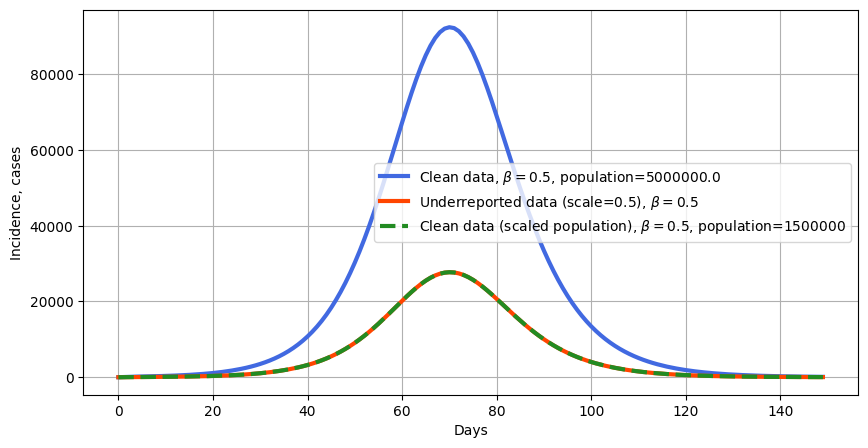

In [3]:
population = 5*1e6
model = SEIRModel(population=population)
R_0 = 2

t_incubation = 2 # in days
t_infective = 4 # in days

alpha = 1/t_incubation
gamma = 1/t_infective
beta = gamma*R_0
init_inf_frac = 0.0001
init_rec_frac = 0.1
tmax = 150 # days

mean_underreporting = 0.3
data_full = model.simulate(alpha=alpha, beta=beta, gamma=gamma, init_inf_frac=init_inf_frac, init_rec_frac=init_rec_frac)
error_model = NaiveErrorModel(data_full.daily_incidence, mean_delay=0, mean_underreporting=mean_underreporting, error_mode='fixed')
error_model.add_noise()
data_underreported = error_model.incidence_arr

model = SEIRModel(population=population*mean_underreporting)
data_pop_scaled = model.simulate(alpha=alpha, beta=beta, gamma=gamma, init_inf_frac=init_inf_frac, init_rec_frac=init_rec_frac)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data_full.daily_incidence, color='RoyalBlue', lw=3, alpha=1, label=r'Clean data, $\beta={}$, population={}'.format(round(beta, 2), population))
ax.plot(data_underreported, color='OrangeRed', alpha=1, lw=3, label=r'Underreported data (scale=0.5), $\beta={}$'.format(round(beta, 2)))
ax.plot(data_pop_scaled.daily_incidence, '--', color='ForestGreen', lw=3, alpha=1, label=r'Clean data (scaled population), $\beta={}$, population={}'.format(round(beta, 2), round(population*mean_underreporting)))

ax.set_xlabel('Days')
ax.set_ylabel('Incidence, cases')
ax.legend()
ax.grid()
fig.savefig('../figures/scale_population.png', bbox_inches='tight')

In [19]:
list(reversed(mean_underreporting_arr))

[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [02:36<26:04, 156.48s/it]C:\Users\user\AppData\Local\Temp\ipykernel_11408\3174301200.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6,6))
100%|██████████| 11/11 [28:54<00:00, 157.68s/it]


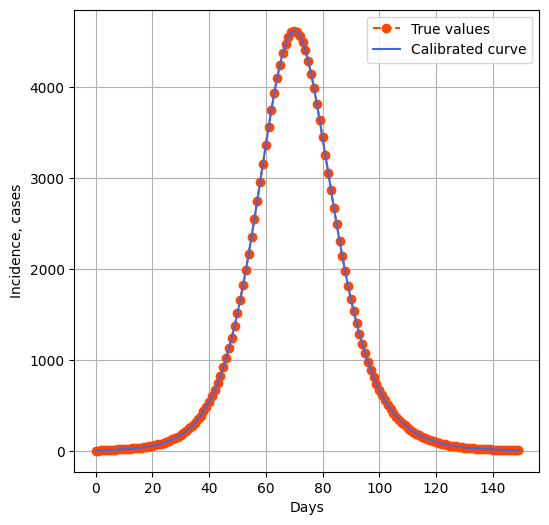

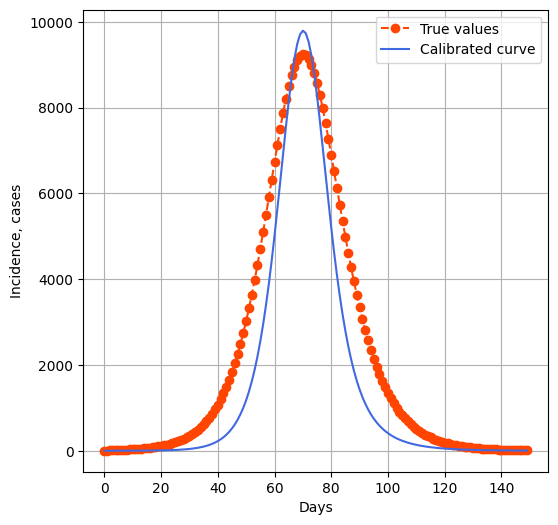

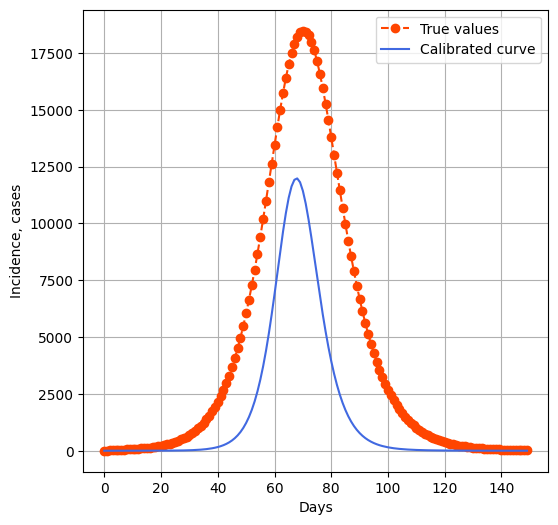

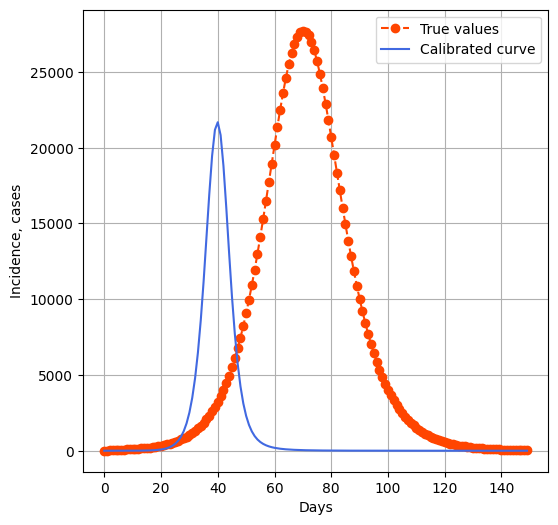

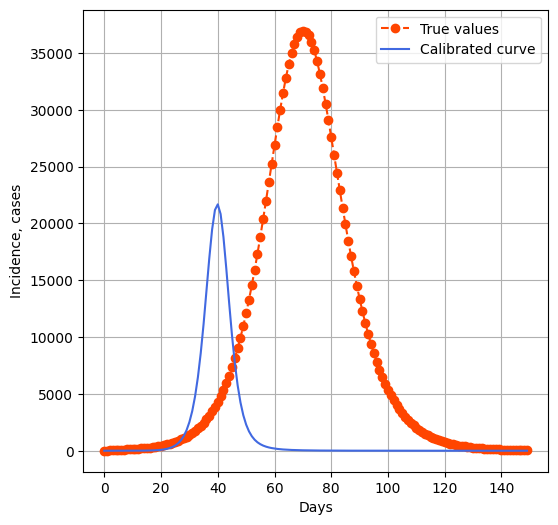

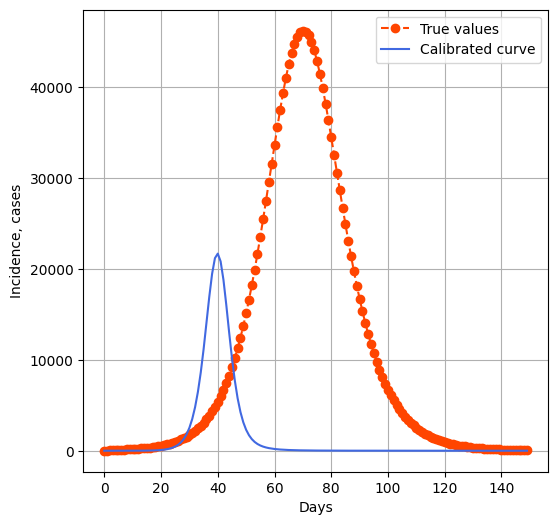

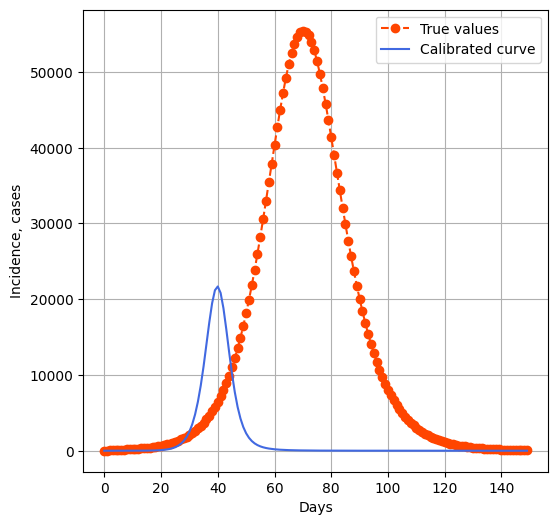

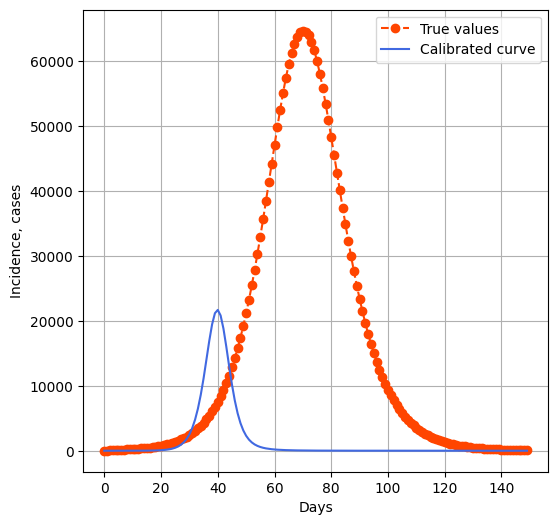

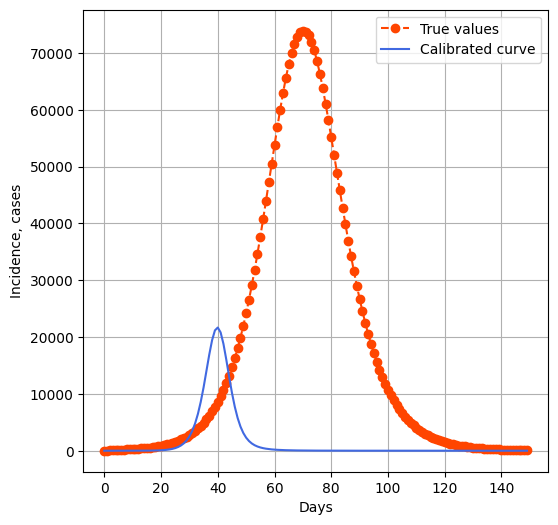

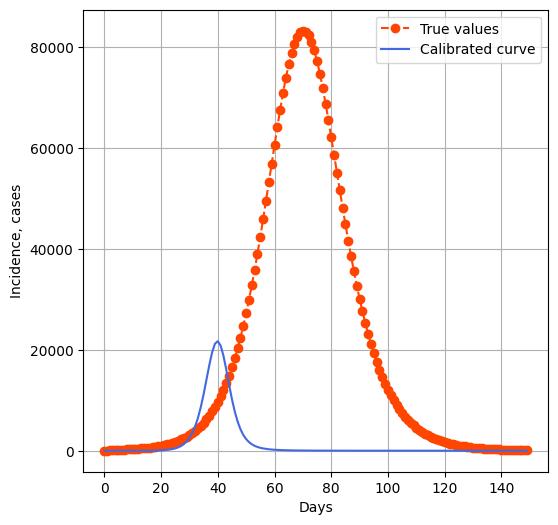

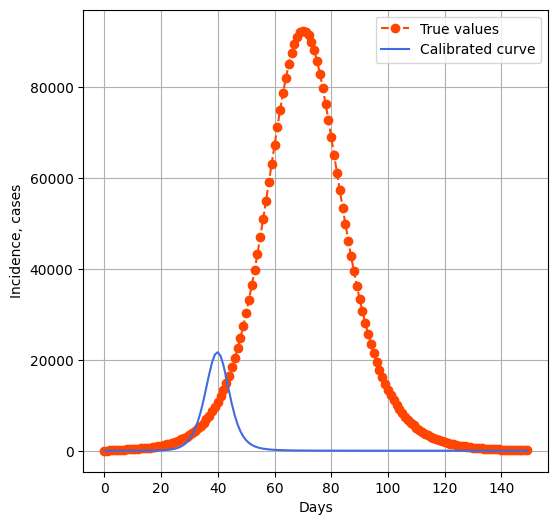

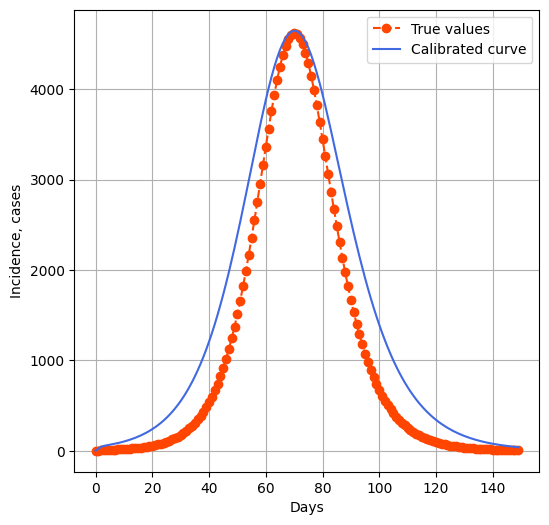

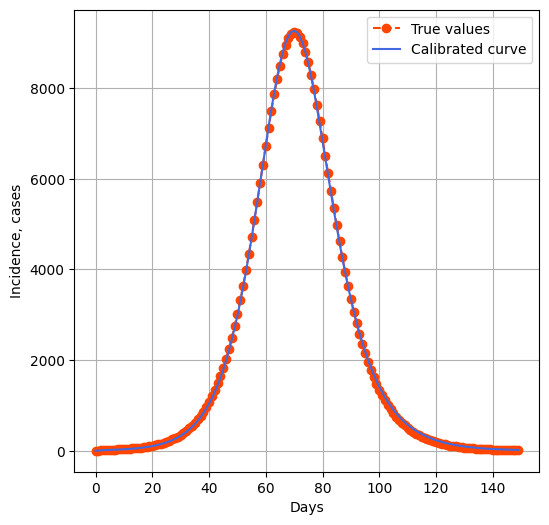

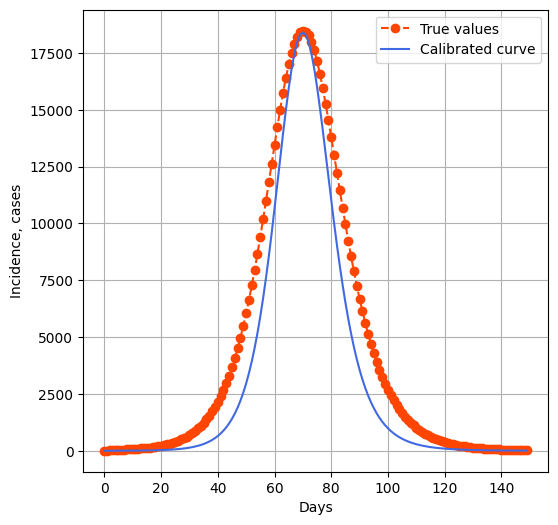

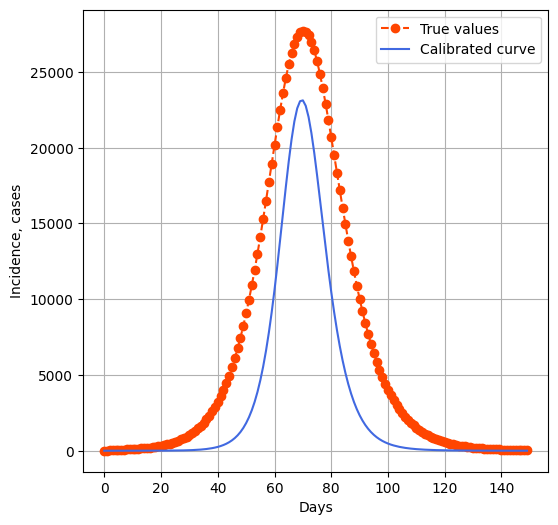

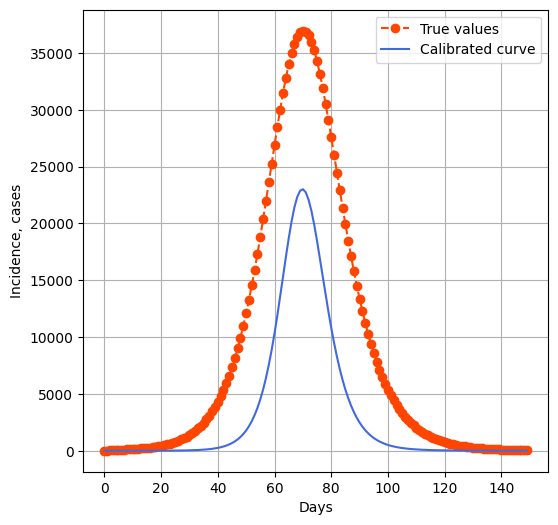

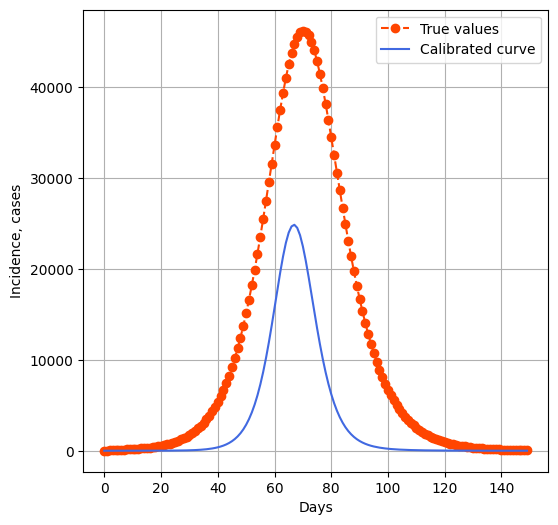

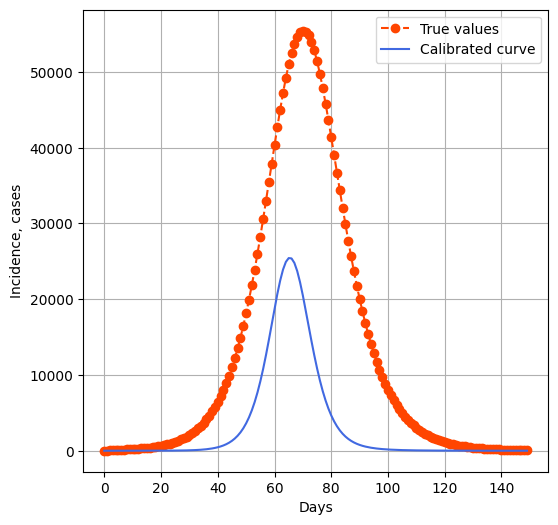

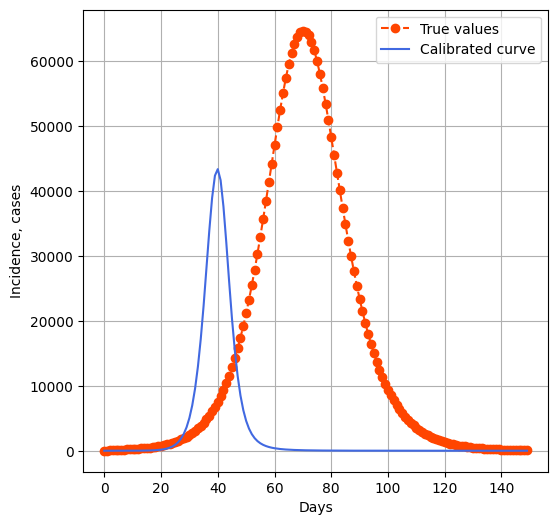

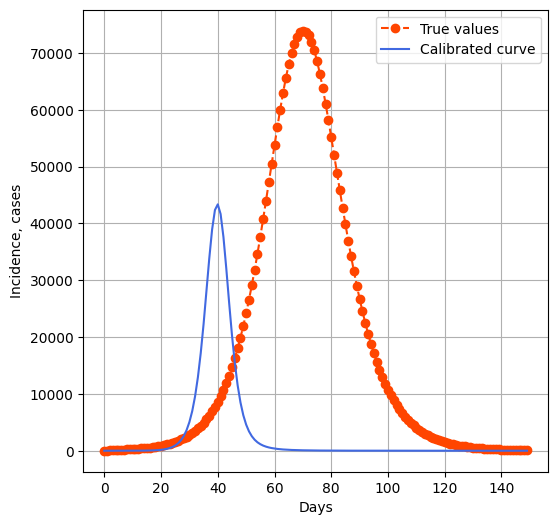

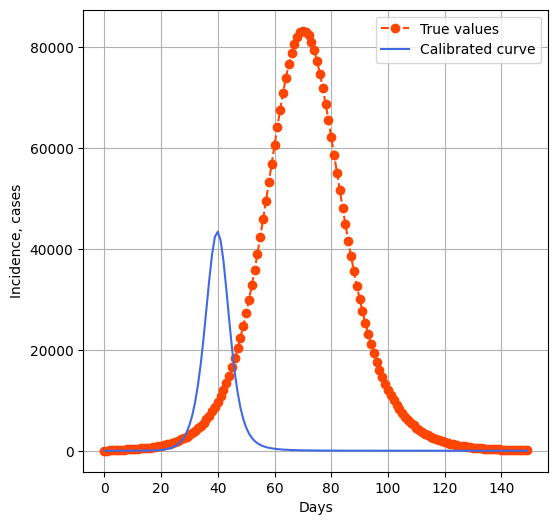

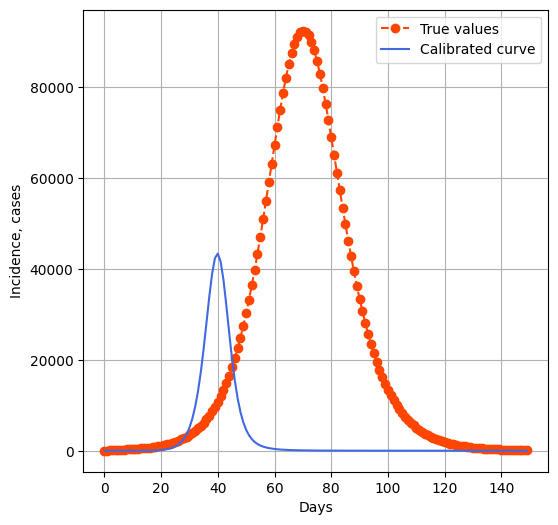

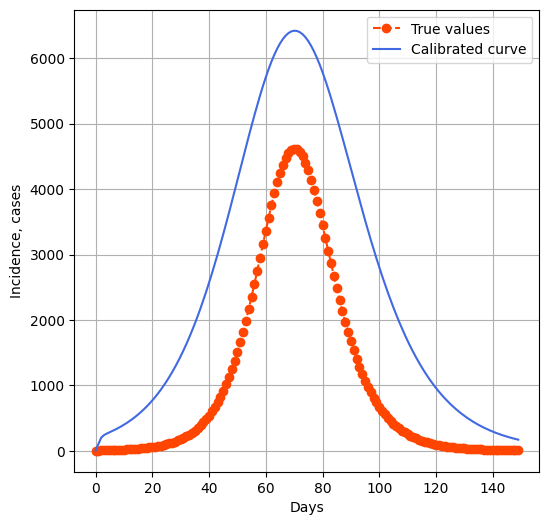

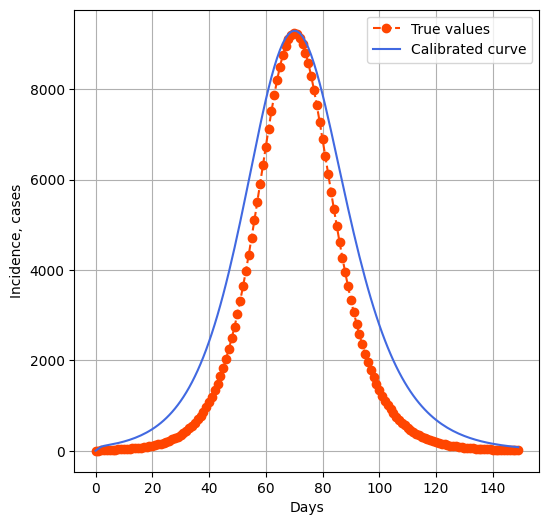

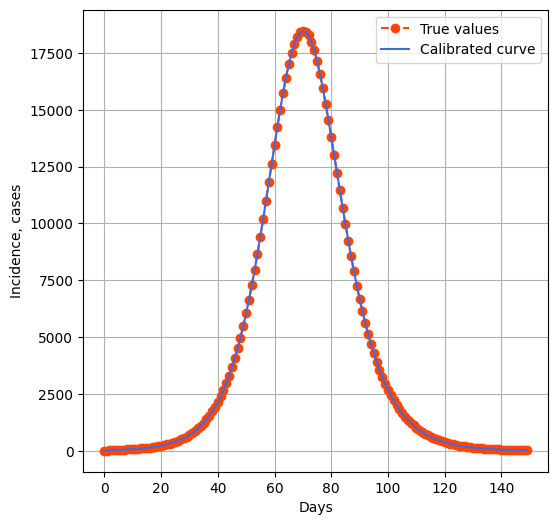

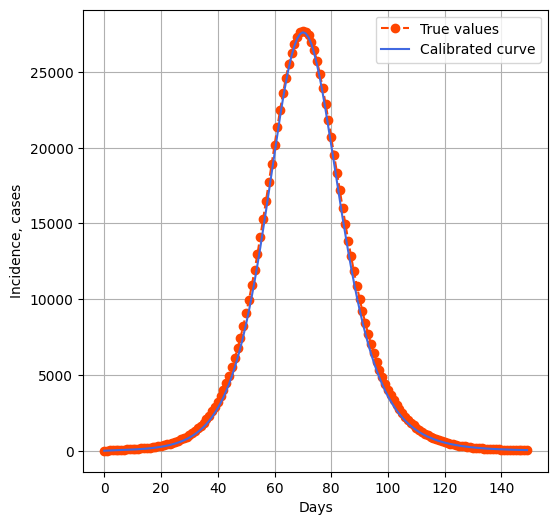

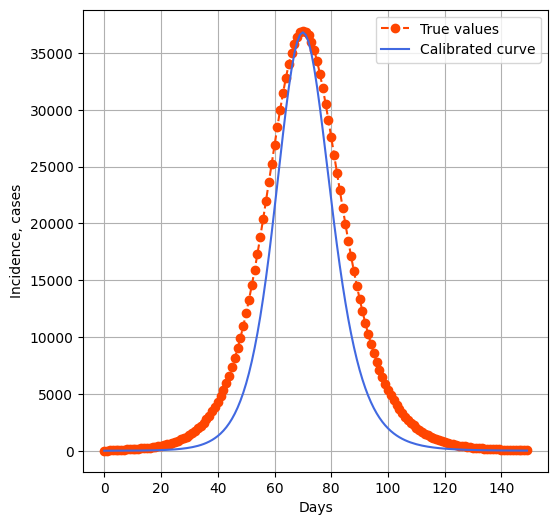

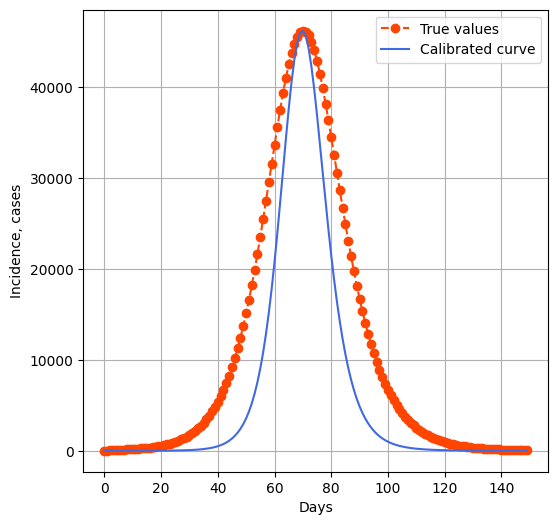

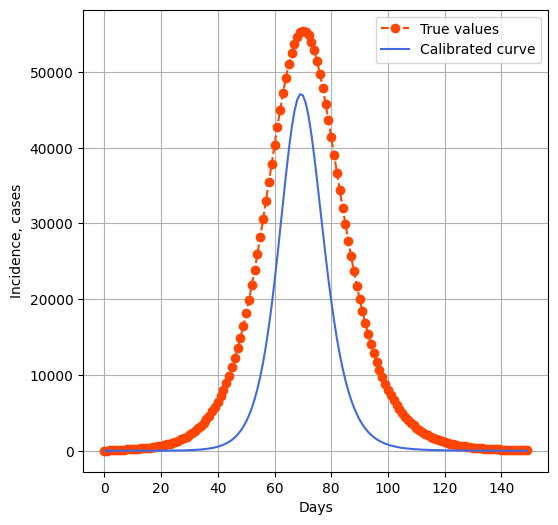

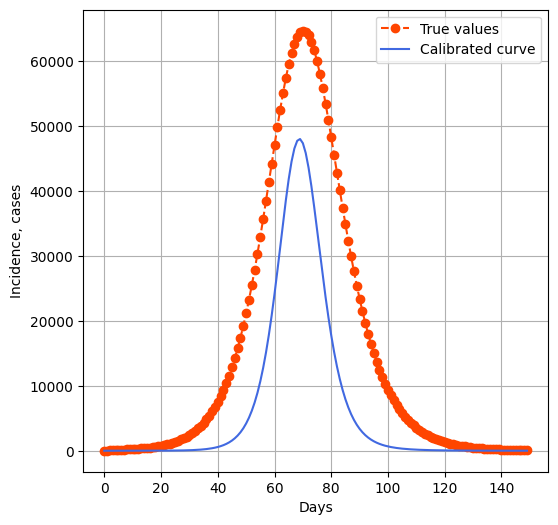

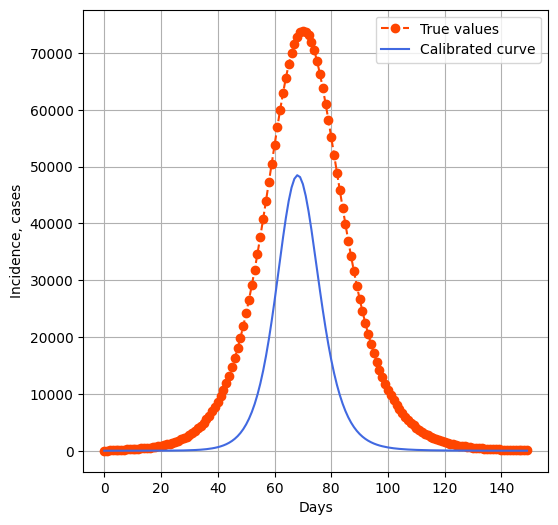

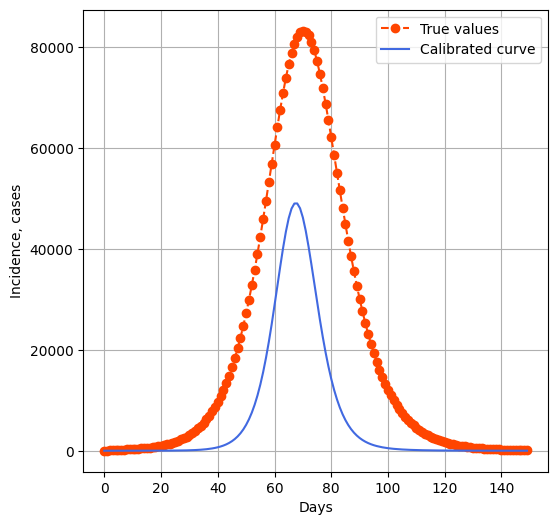

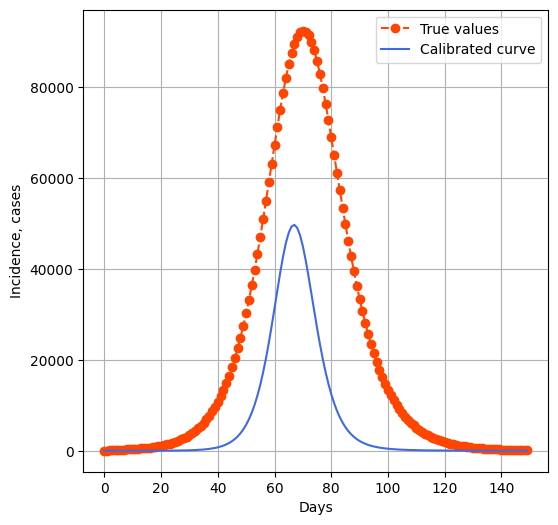

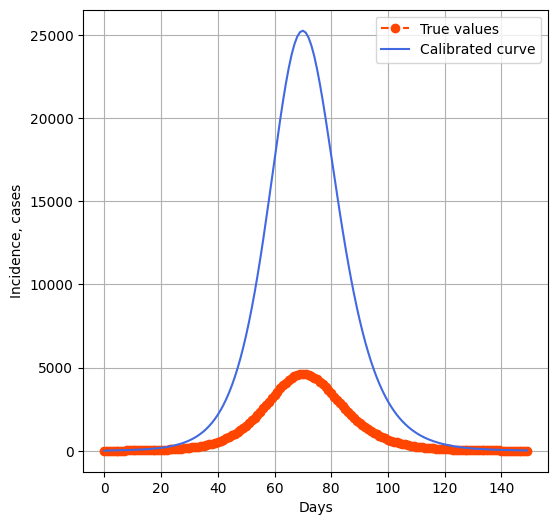

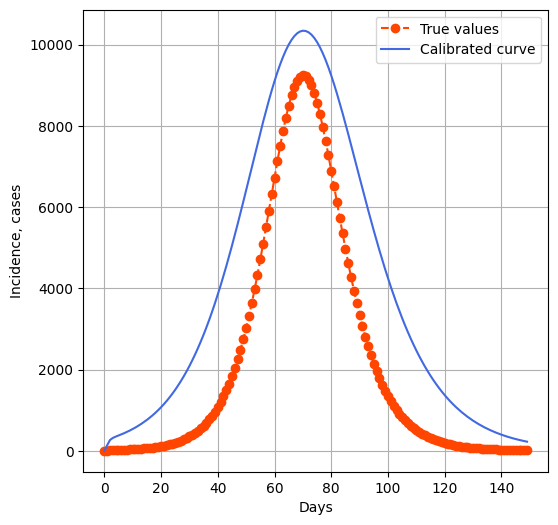

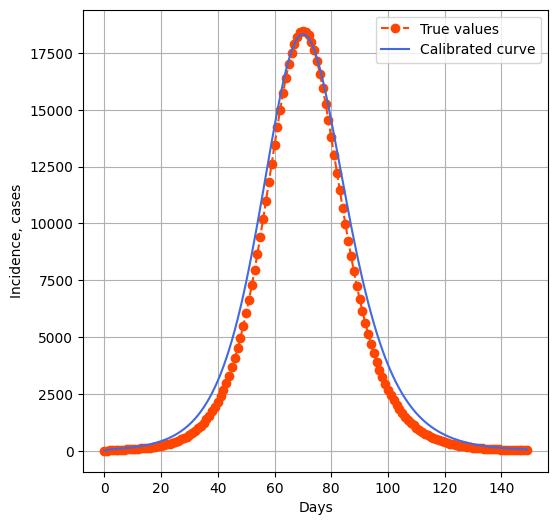

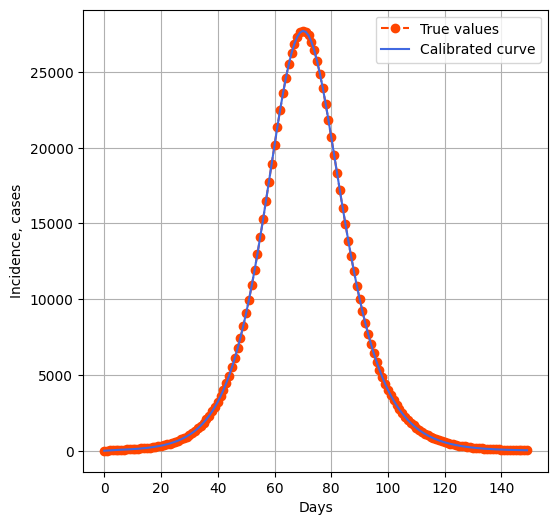

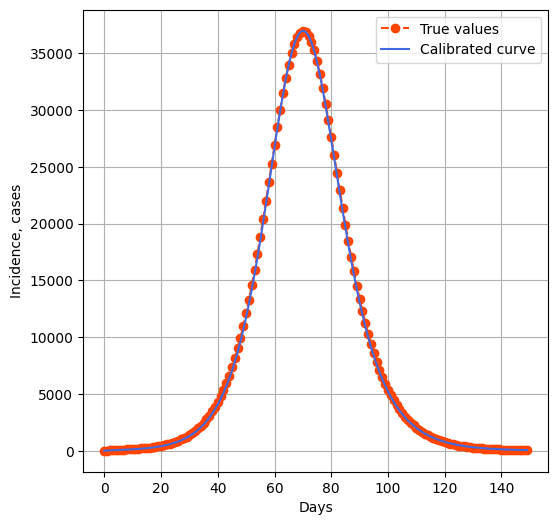

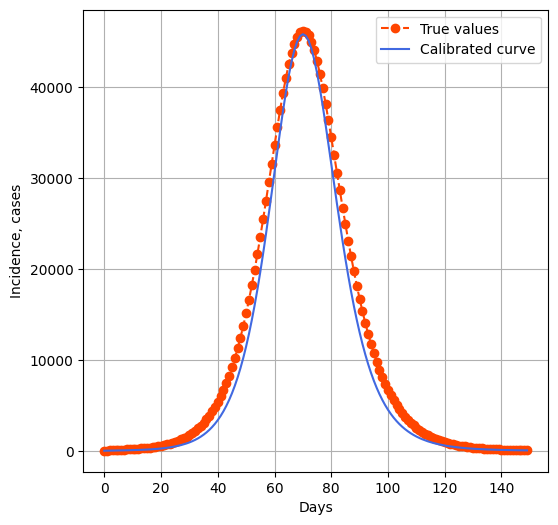

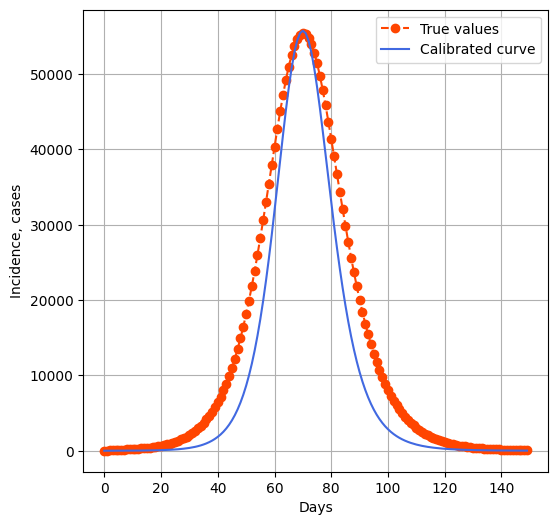

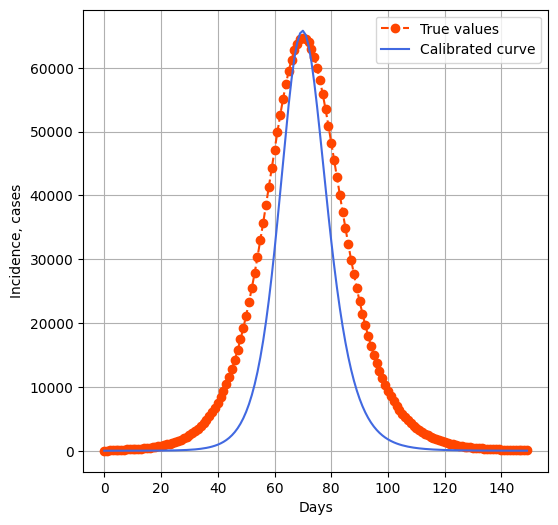

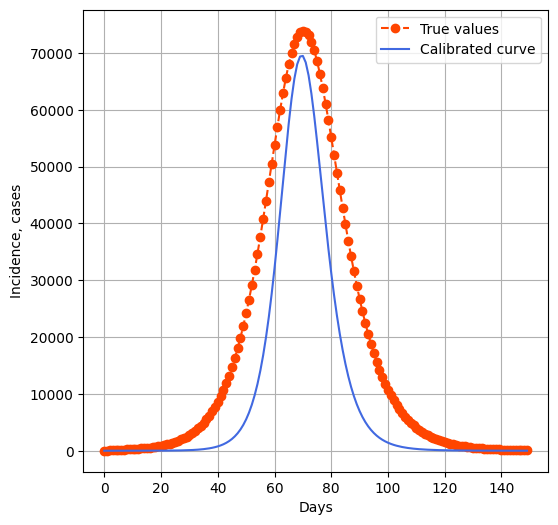

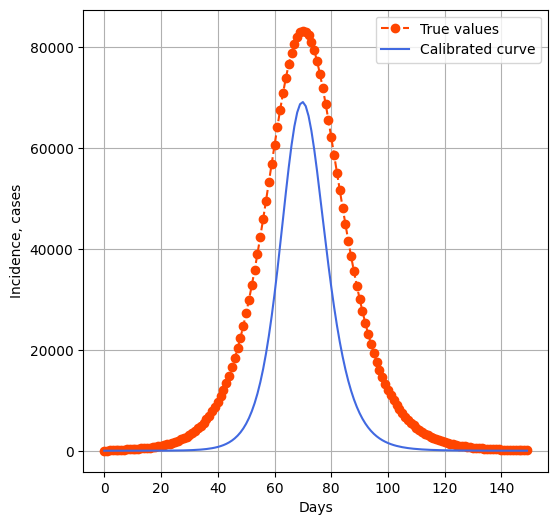

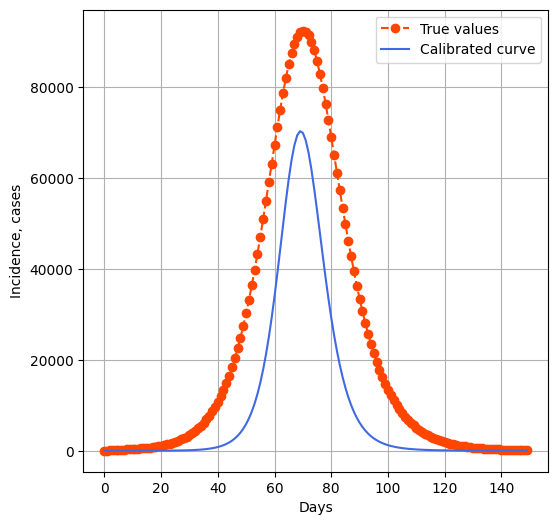

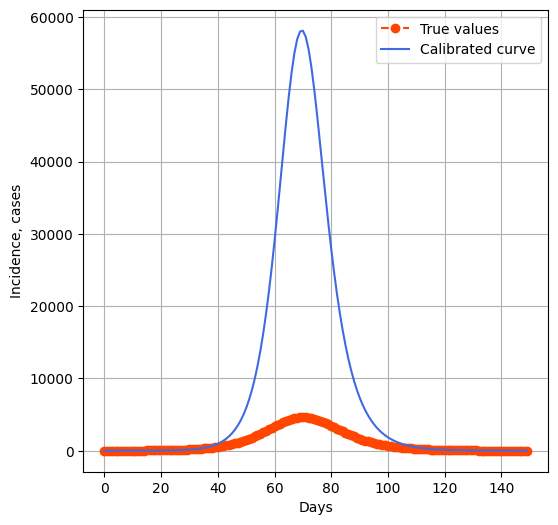

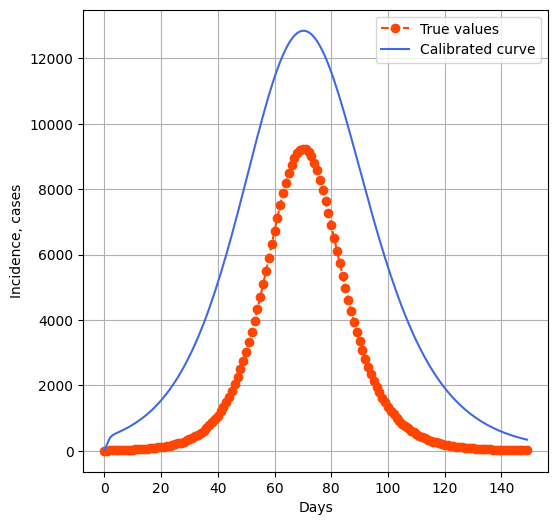

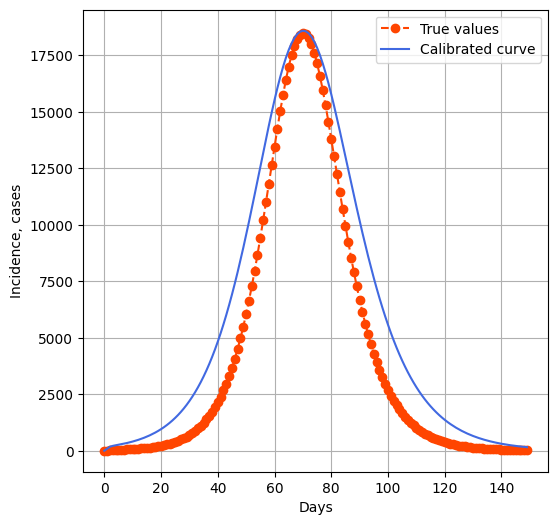

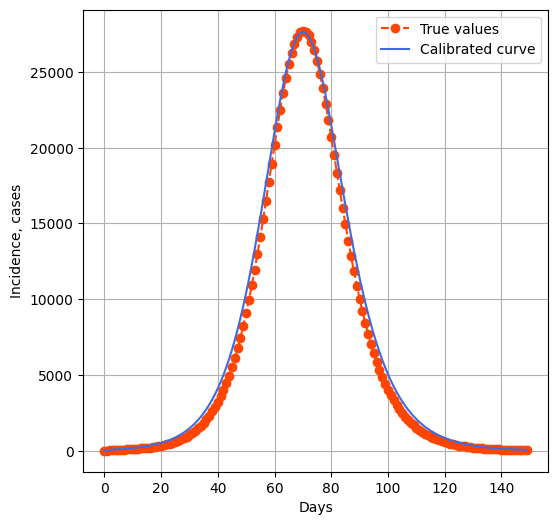

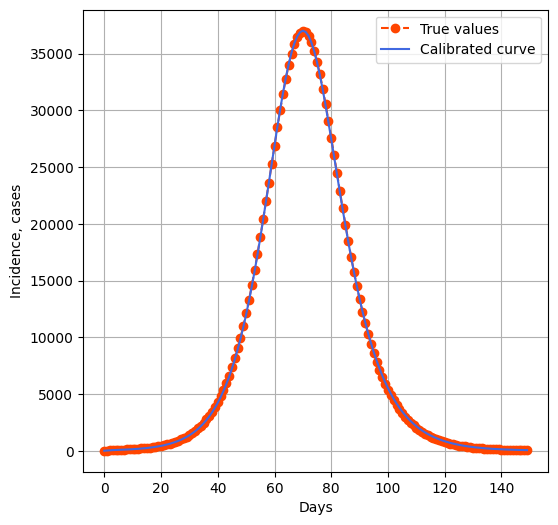

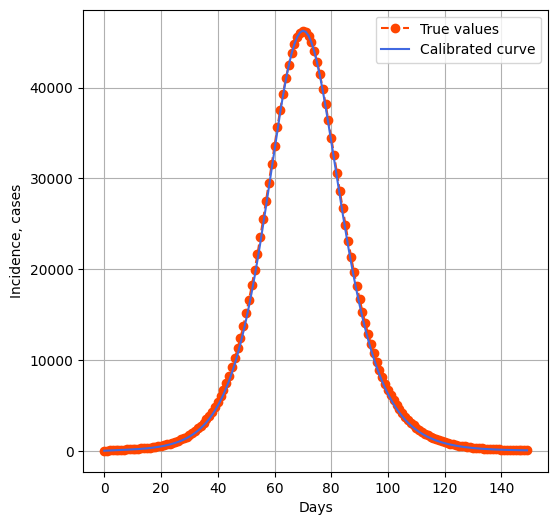

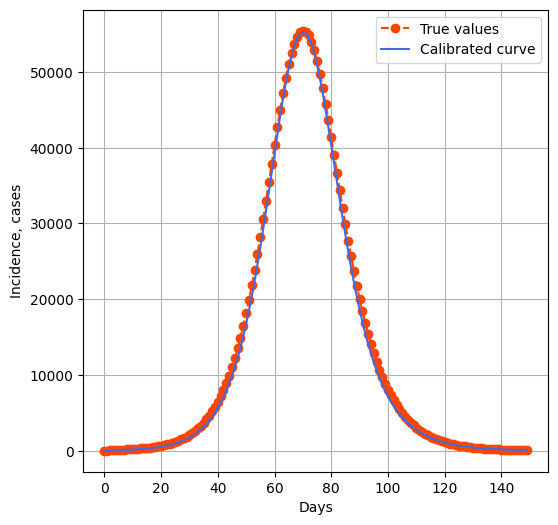

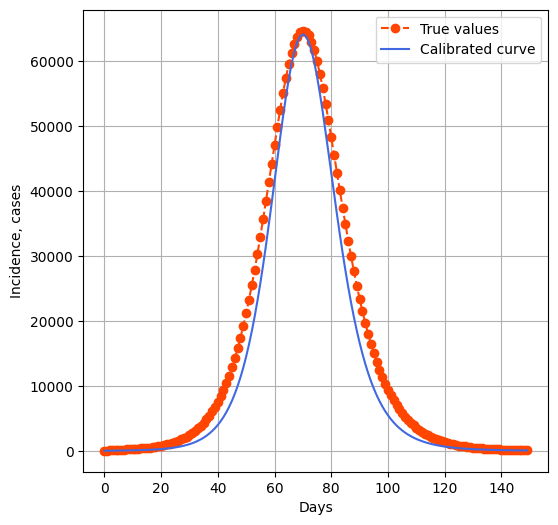

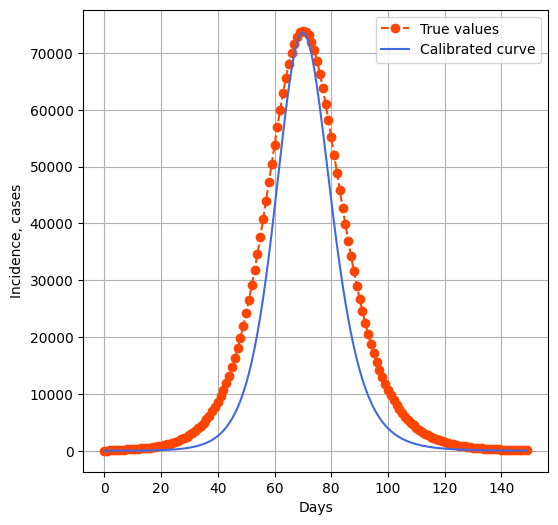

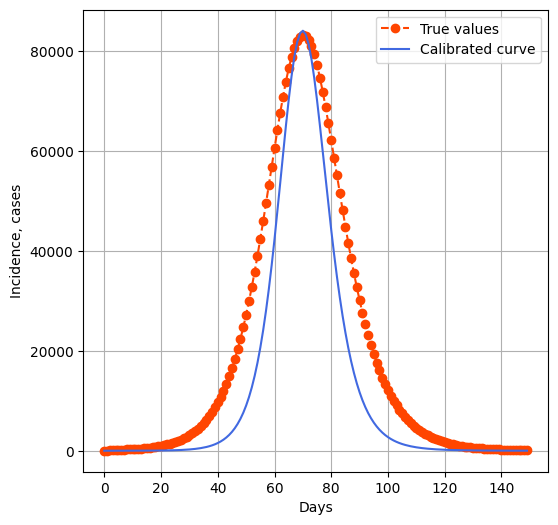

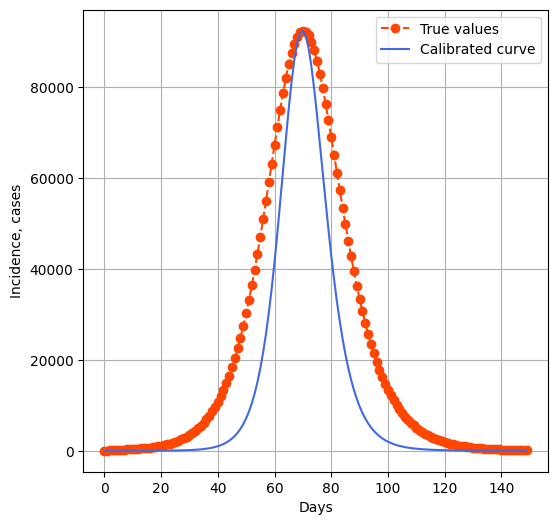

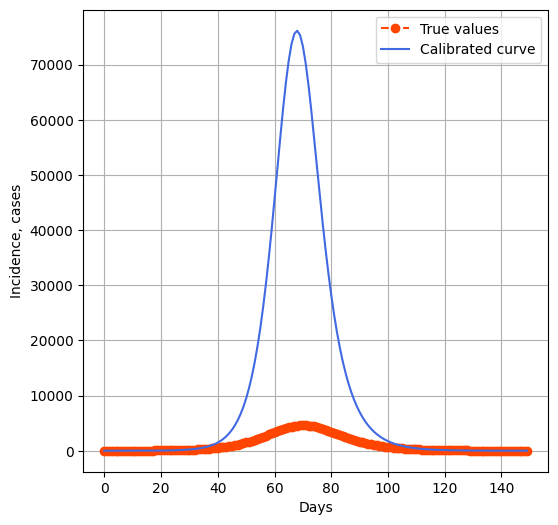

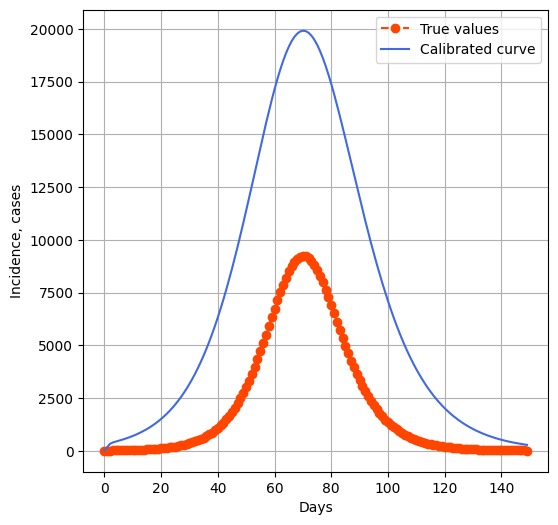

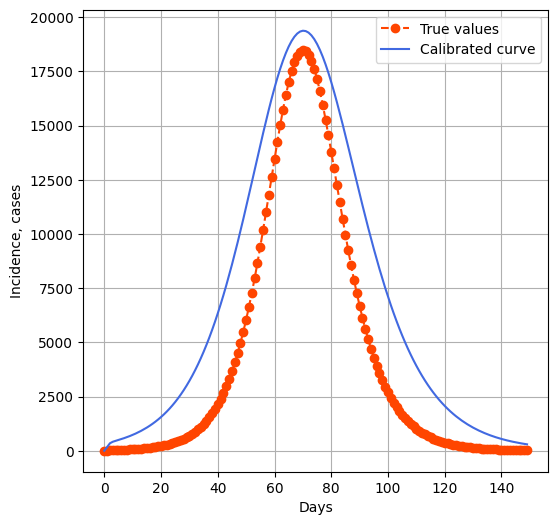

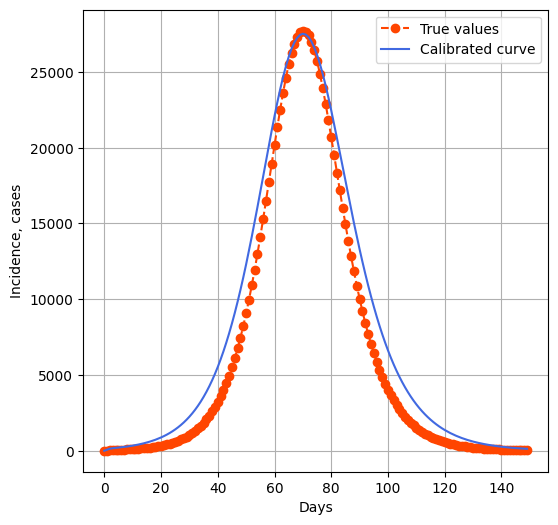

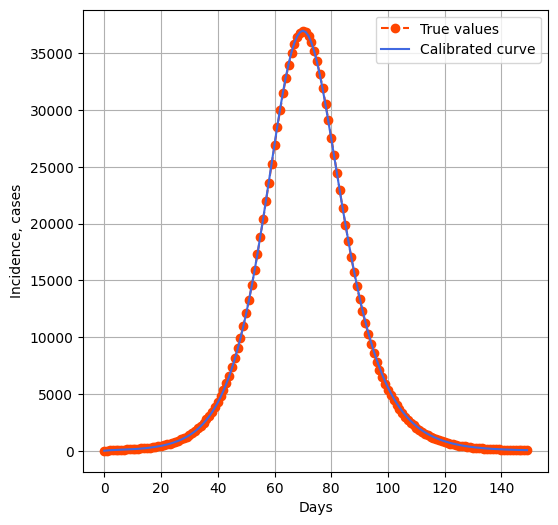

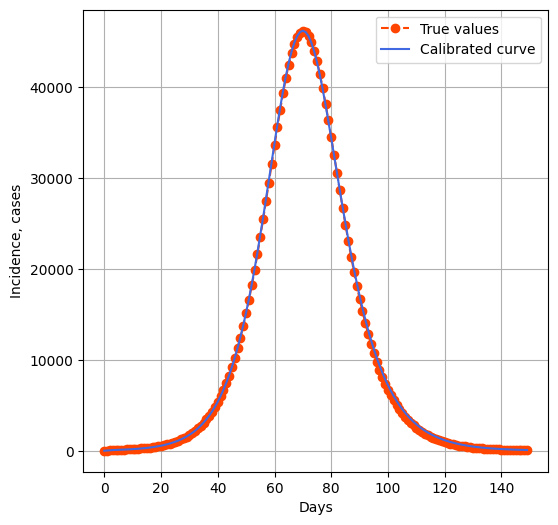

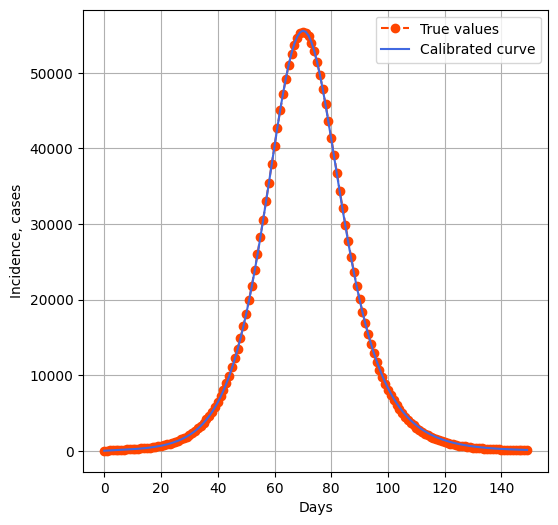

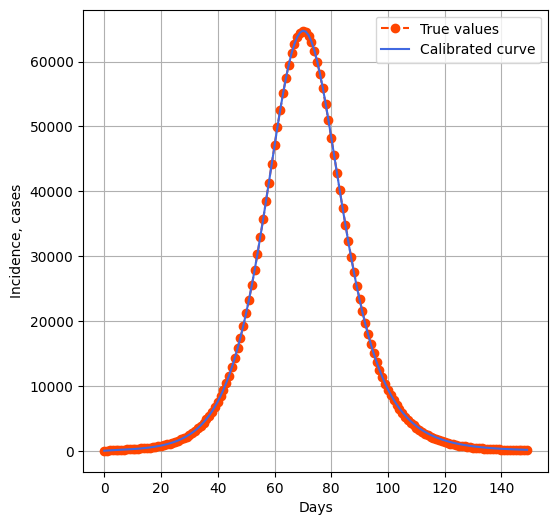

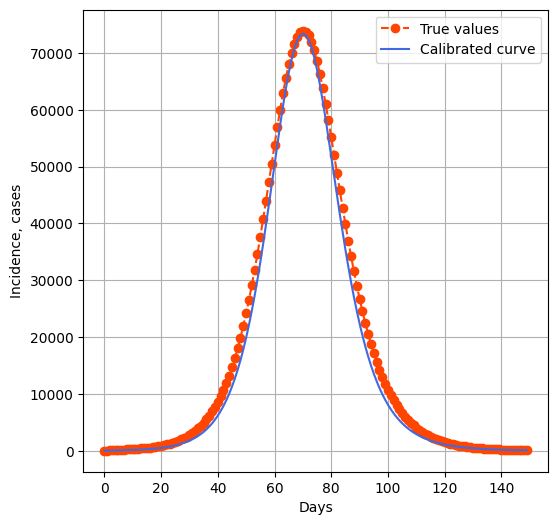

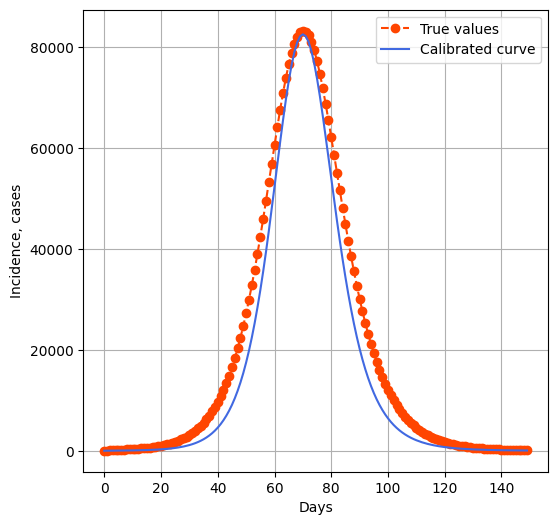

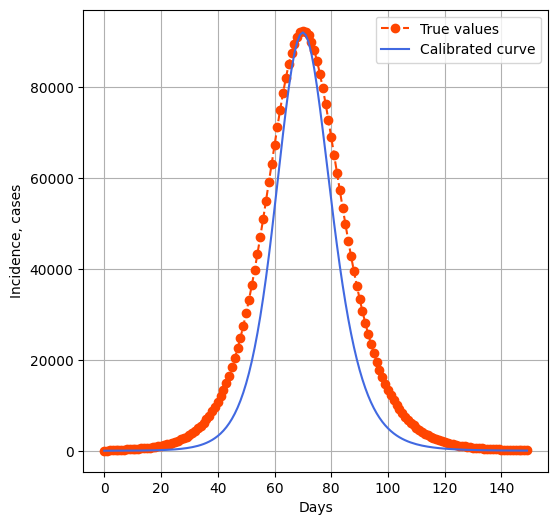

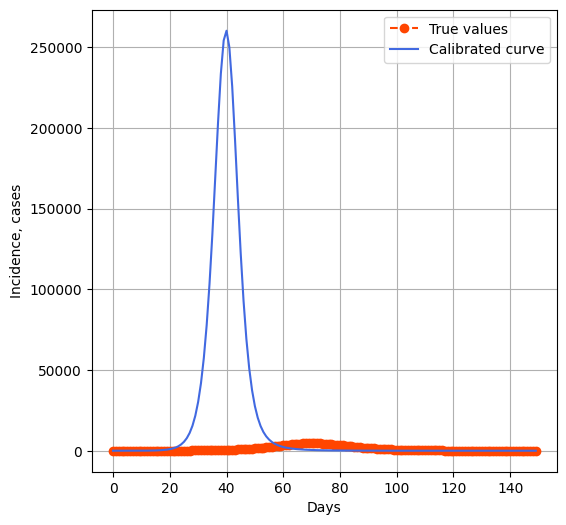

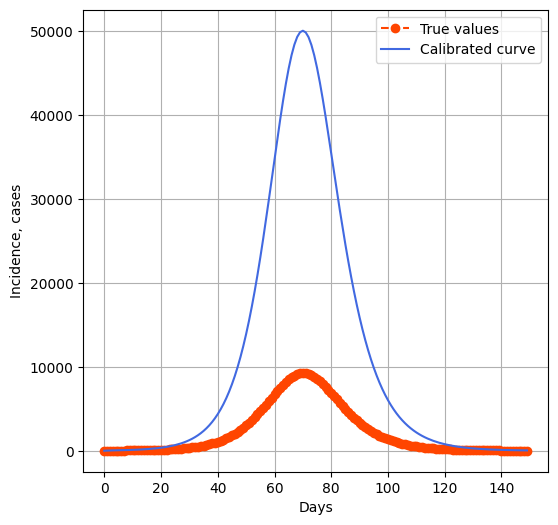

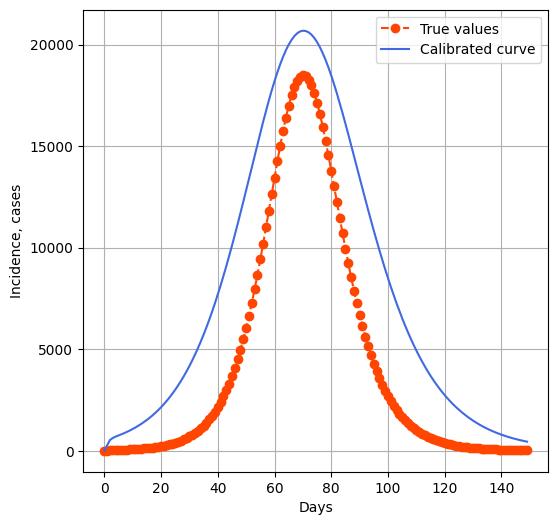

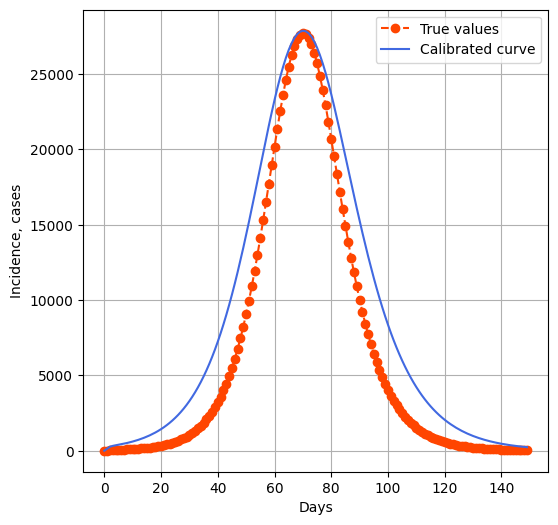

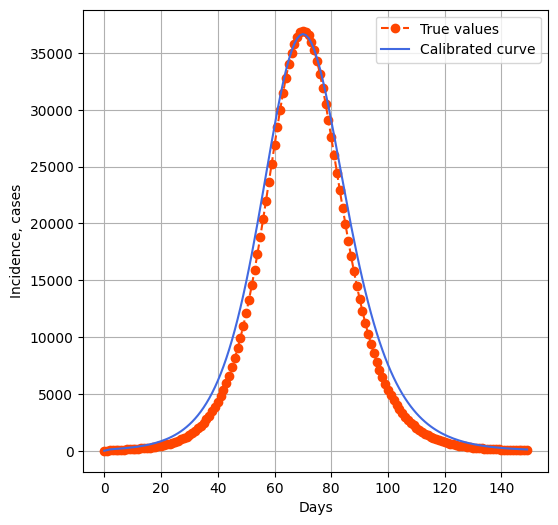

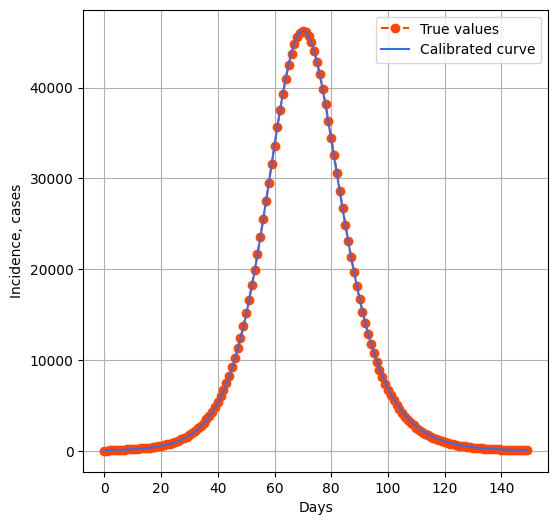

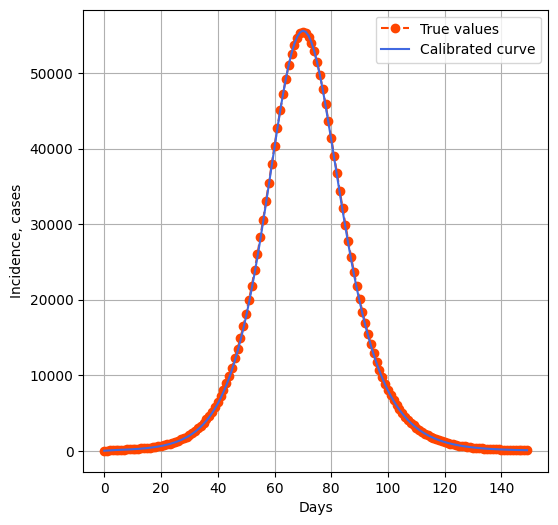

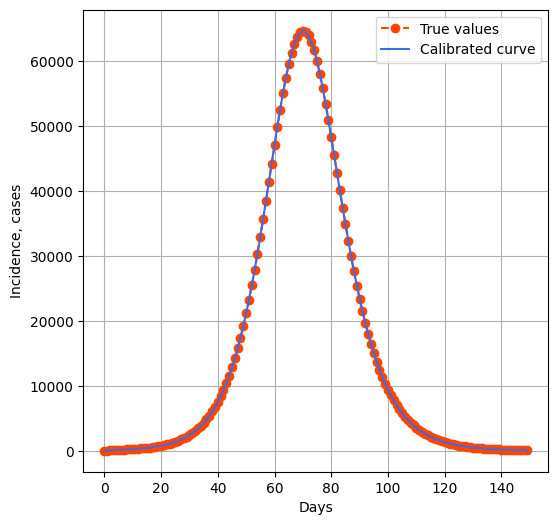

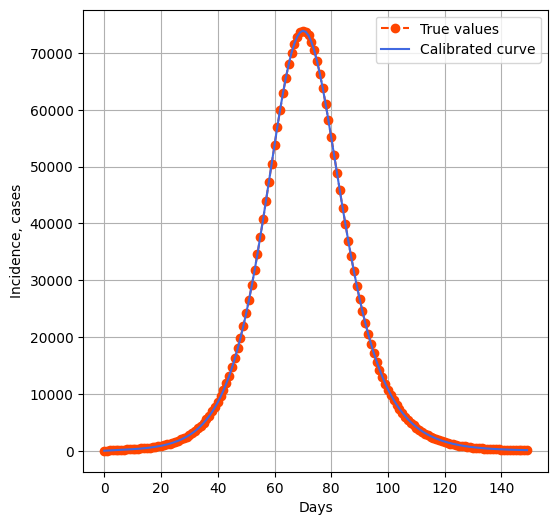

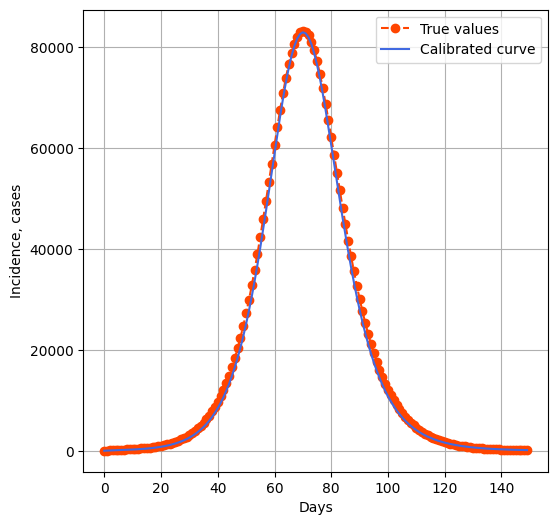

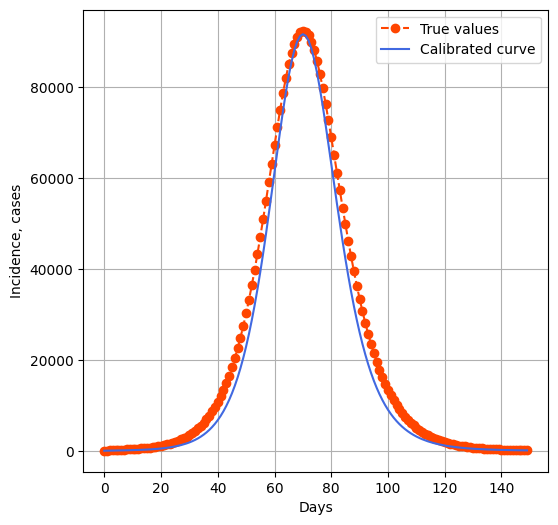

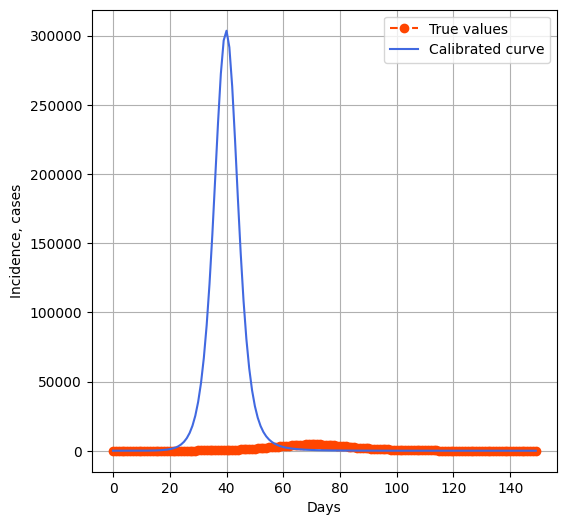

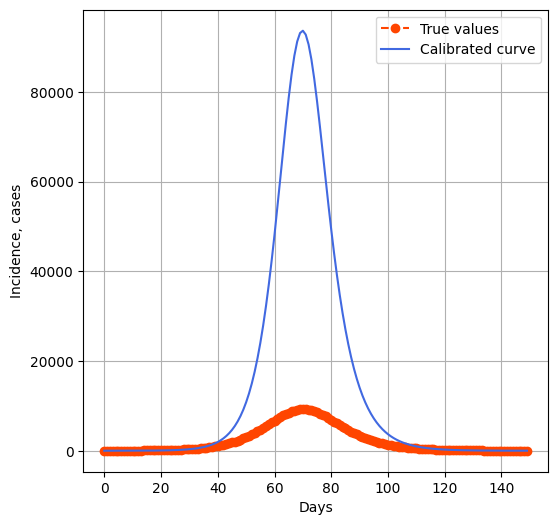

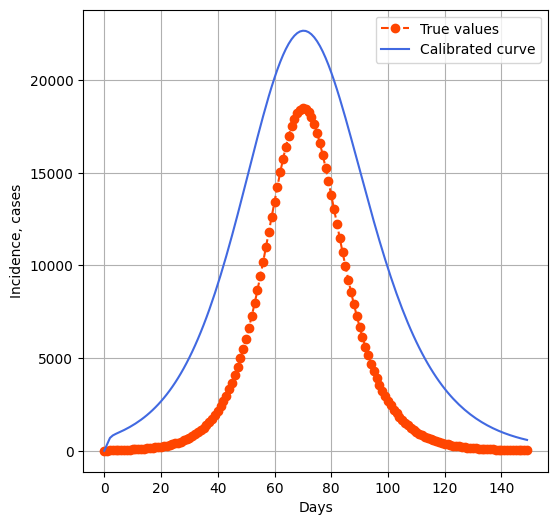

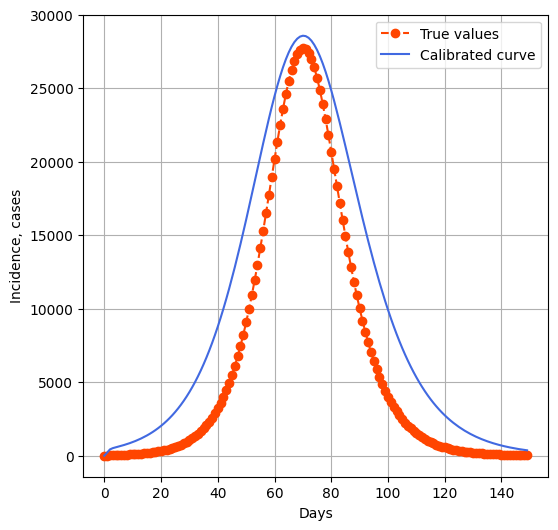

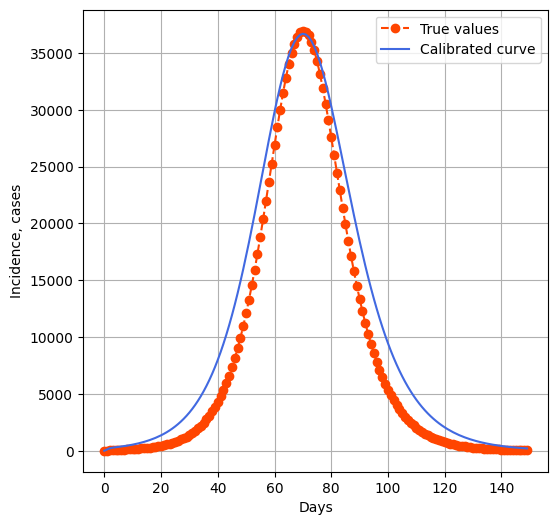

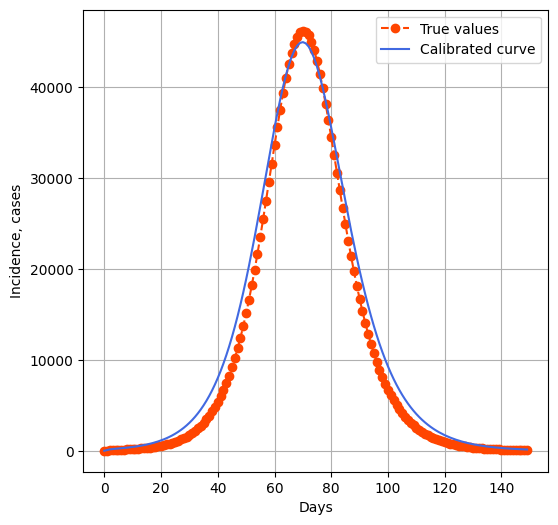

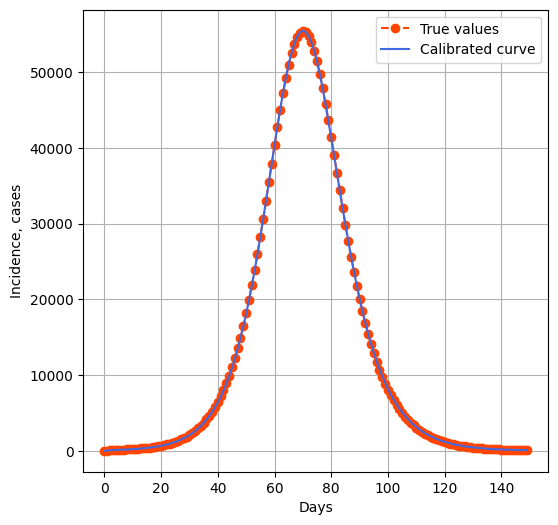

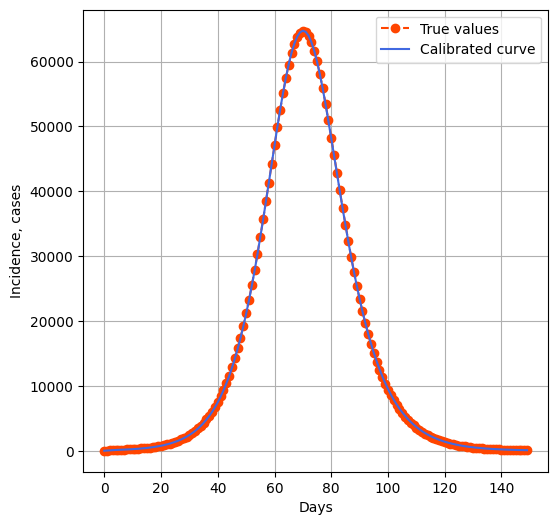

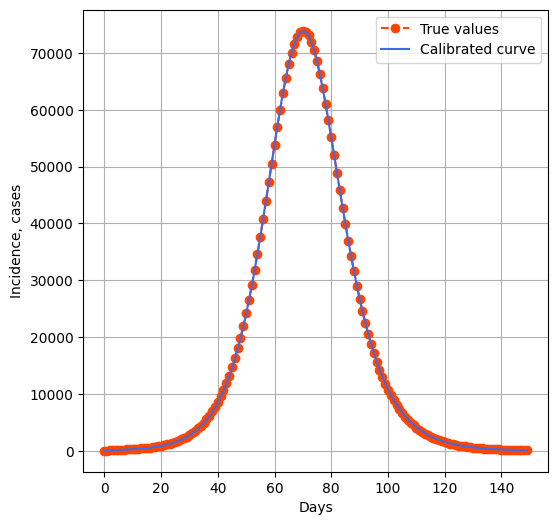

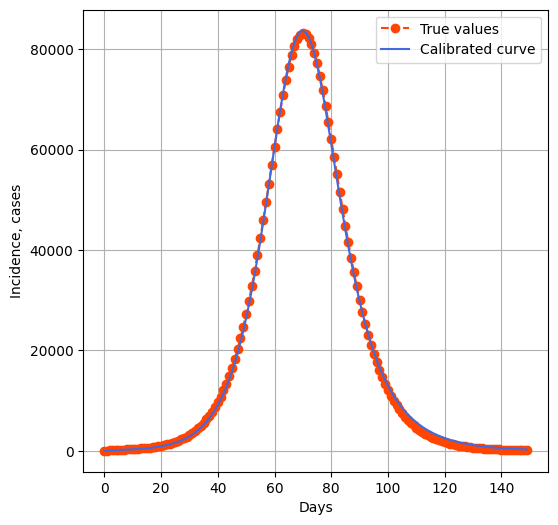

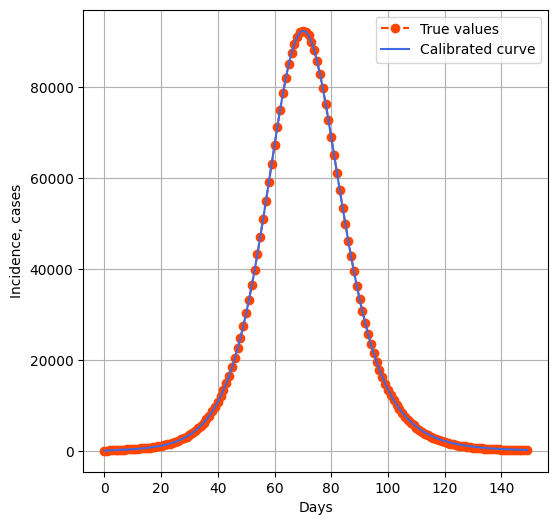

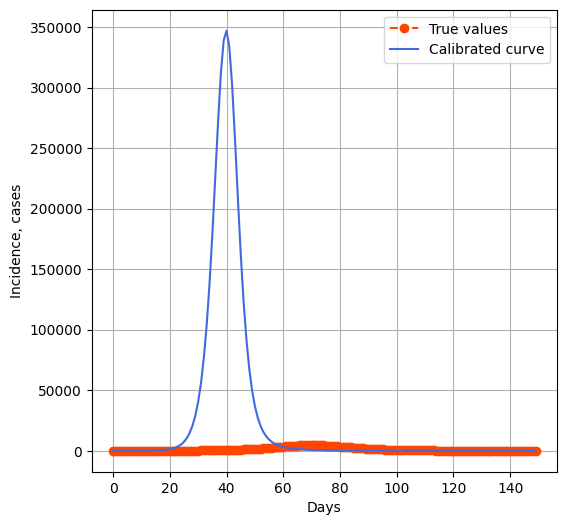

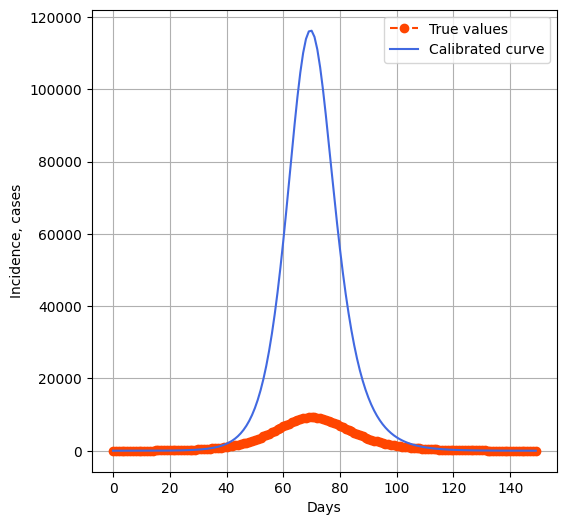

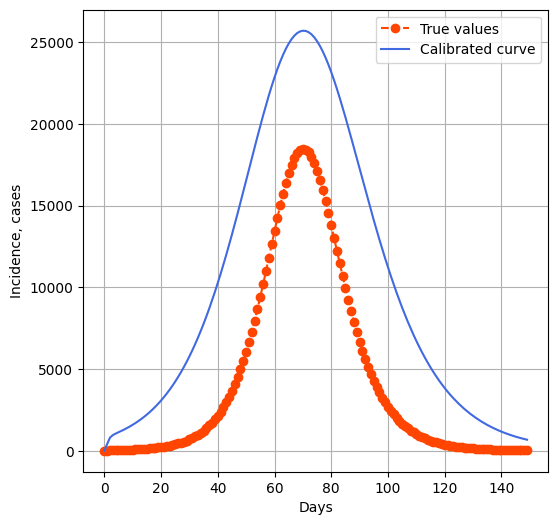

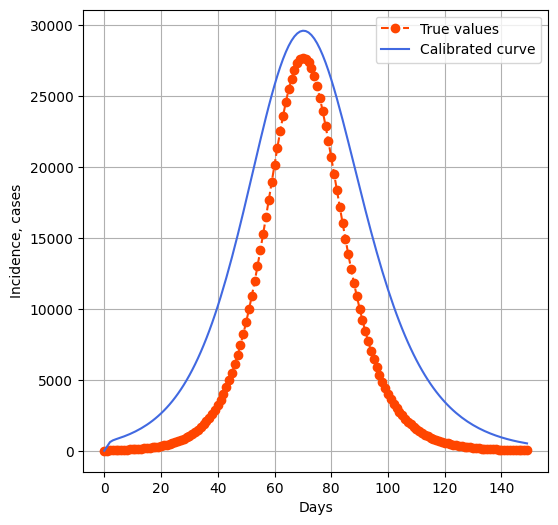

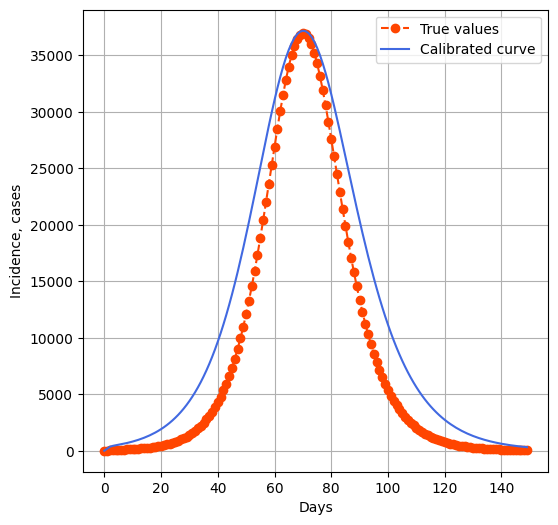

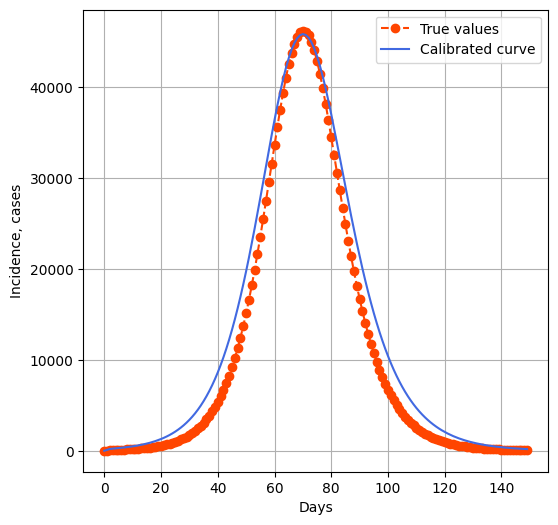

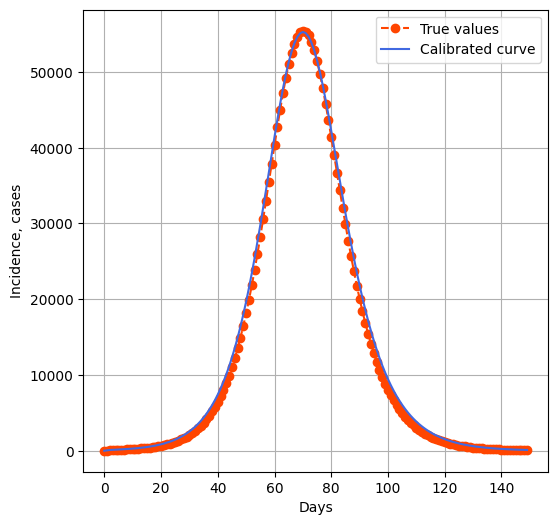

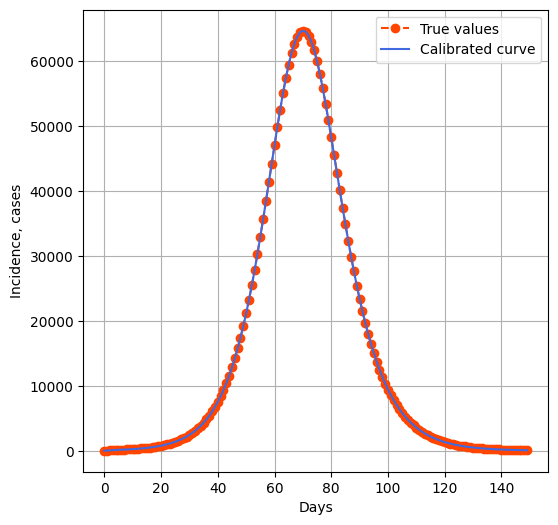

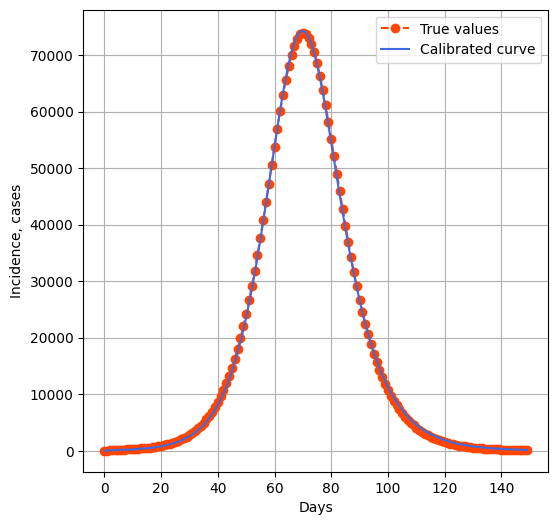

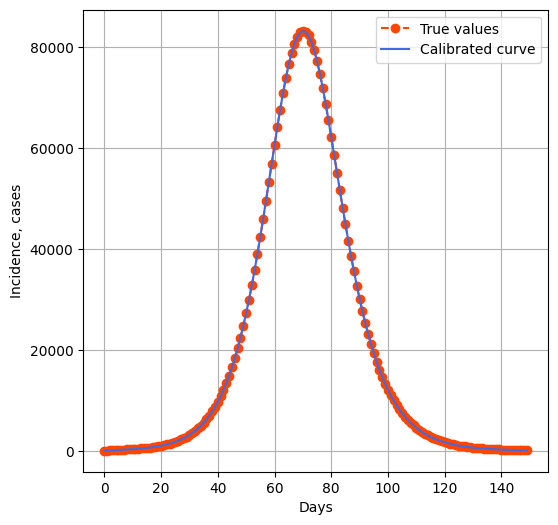

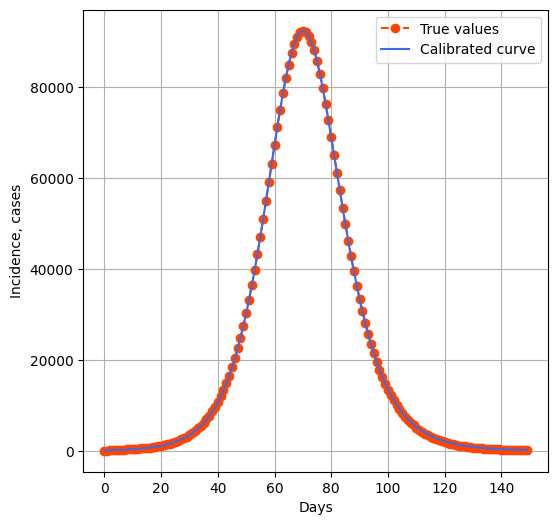

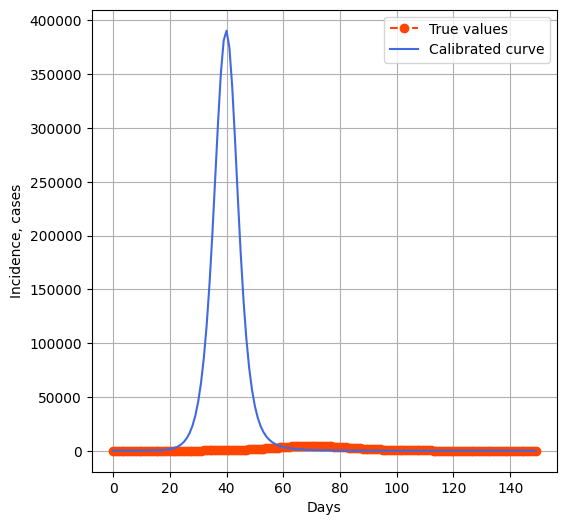

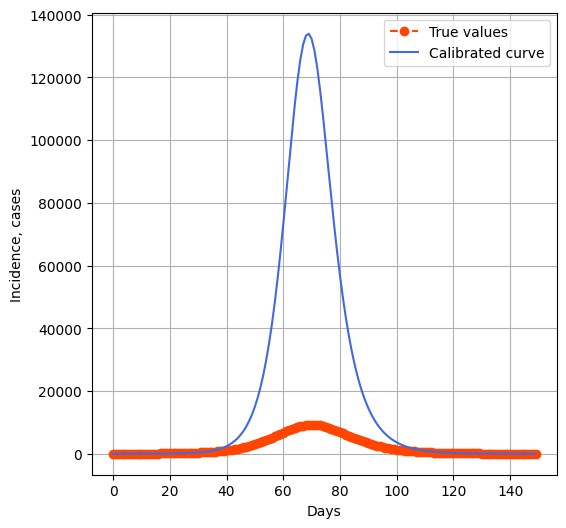

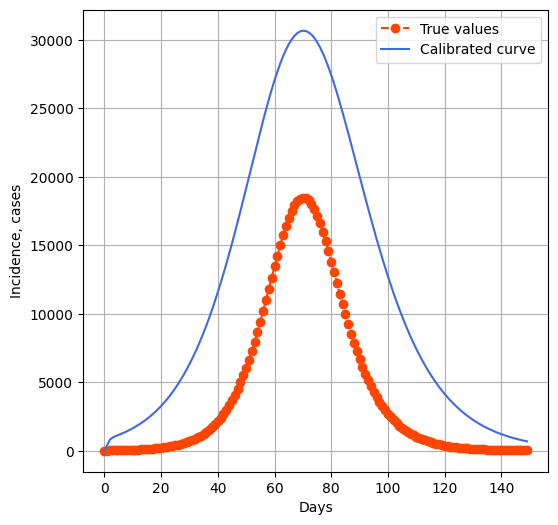

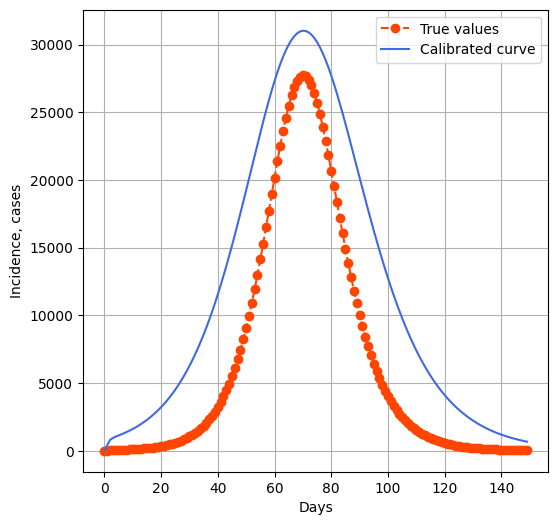

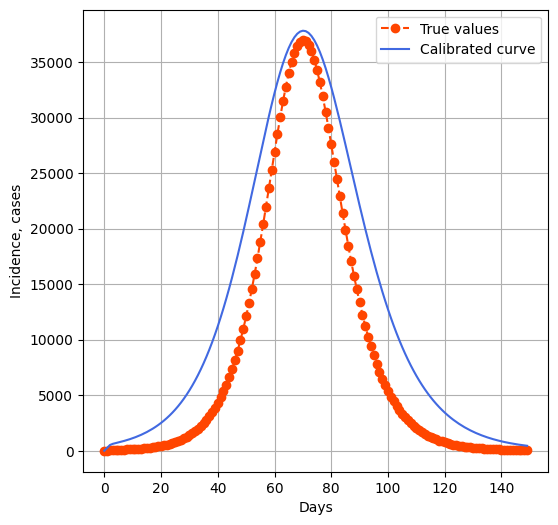

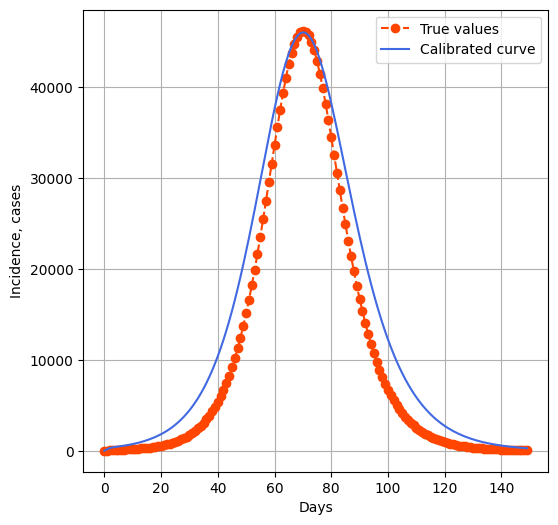

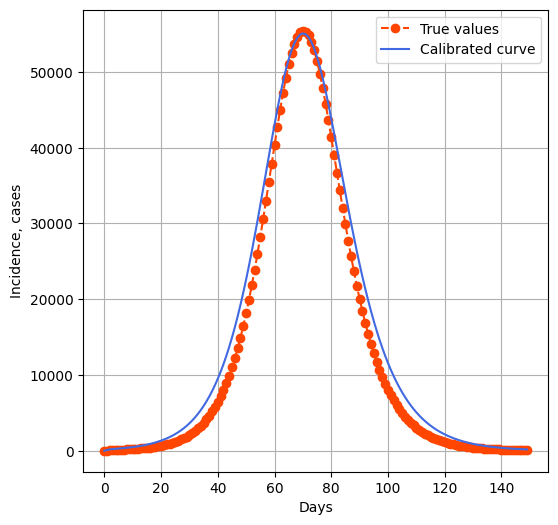

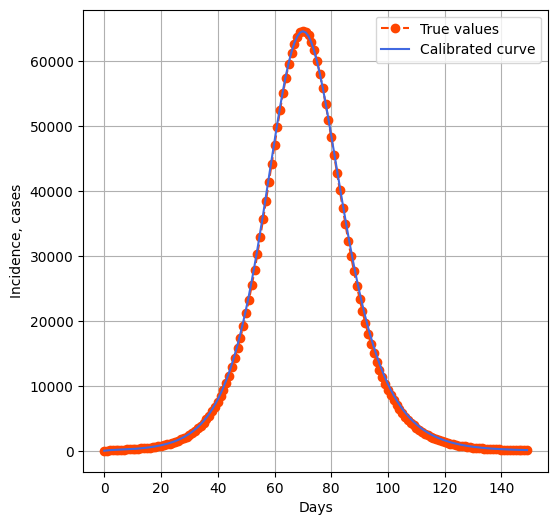

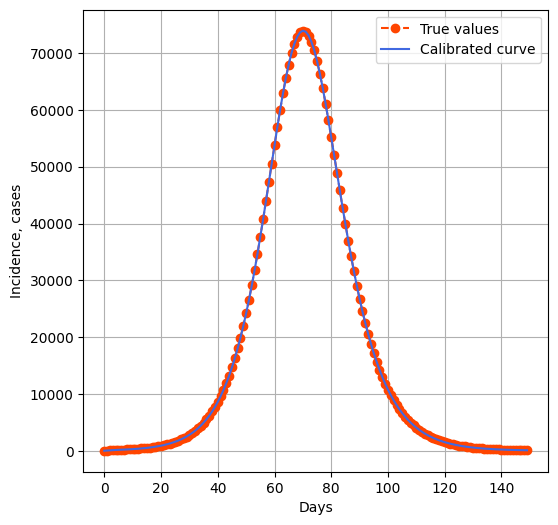

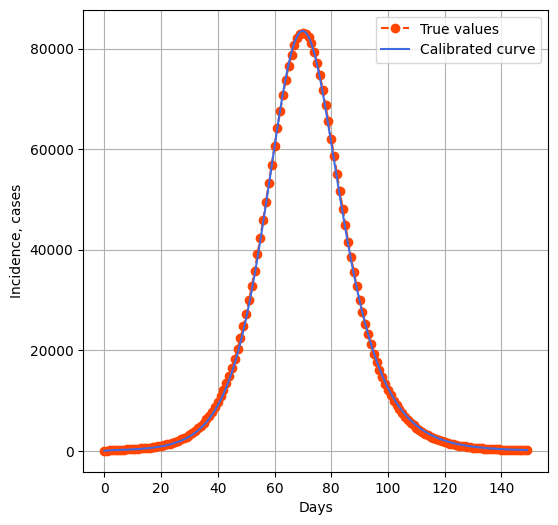

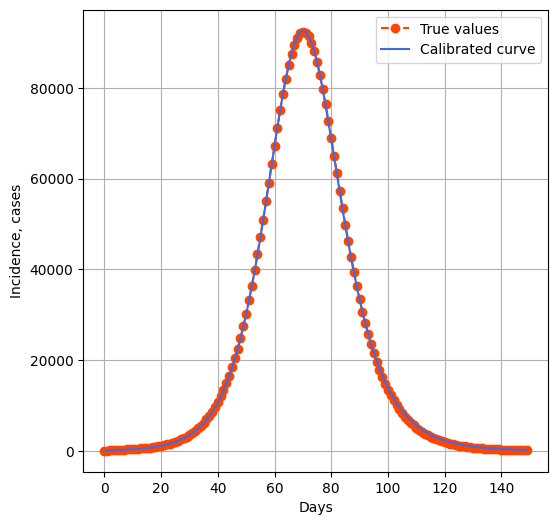

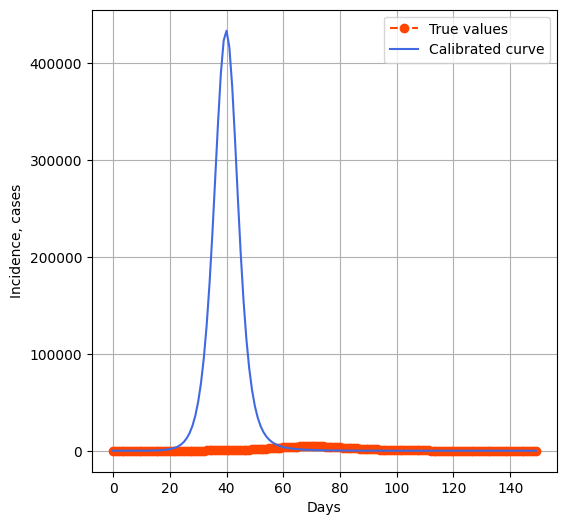

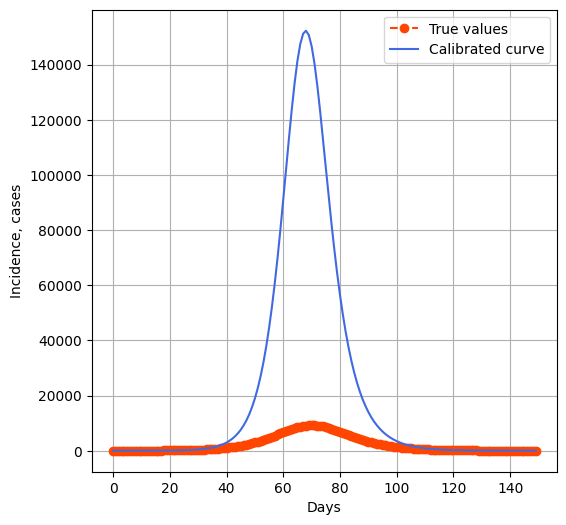

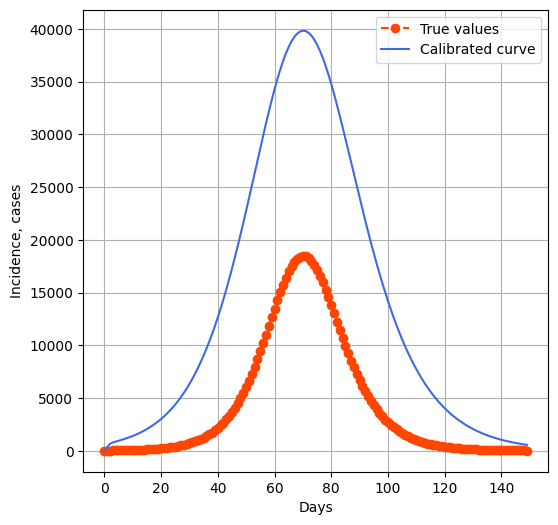

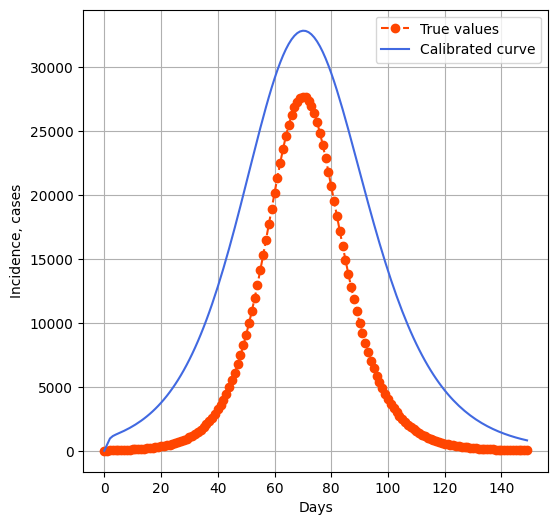

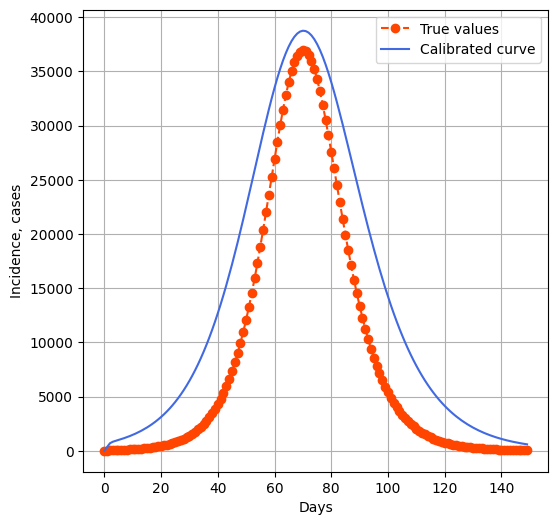

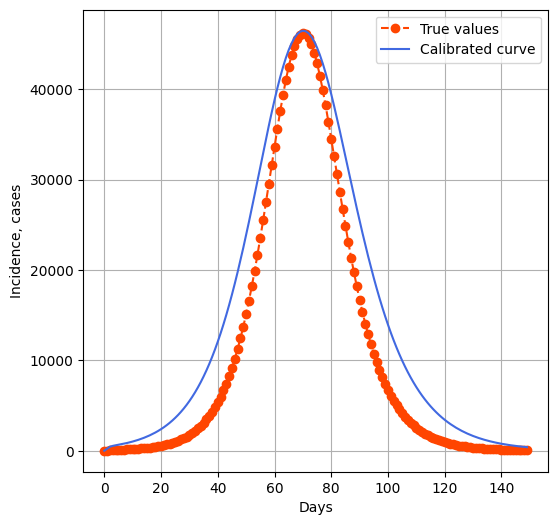

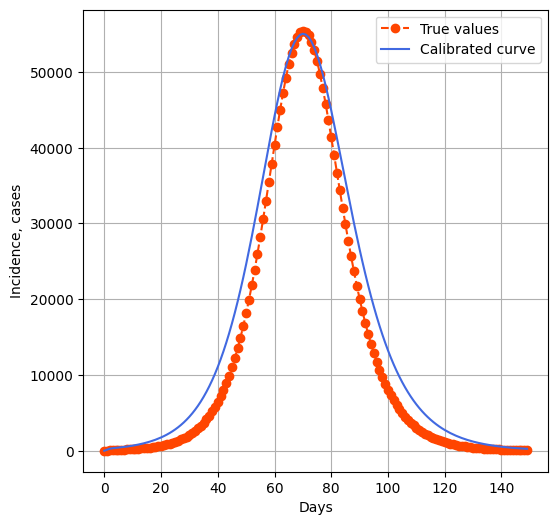

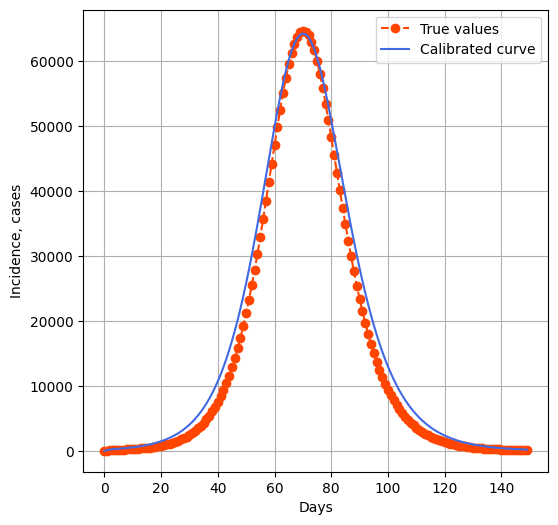

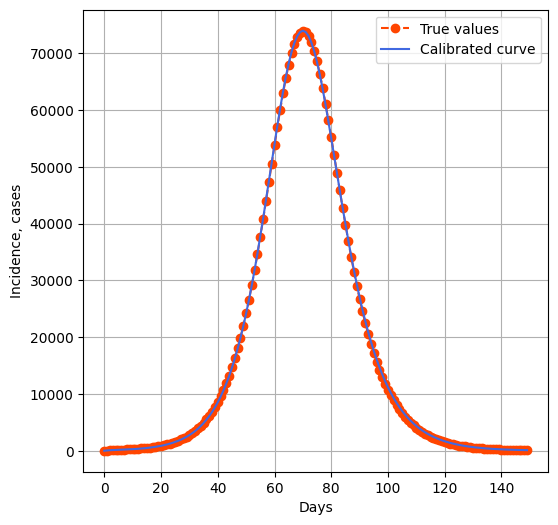

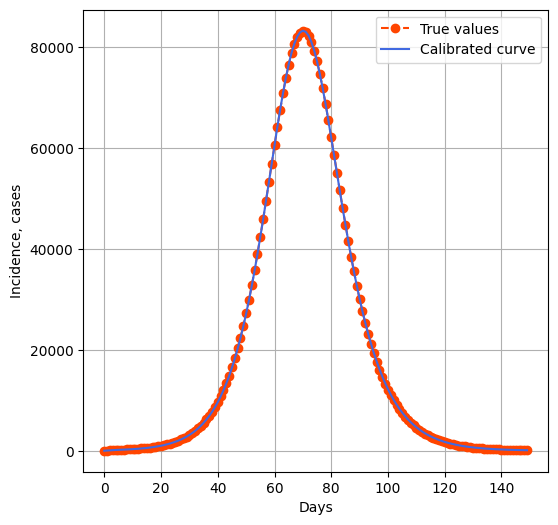

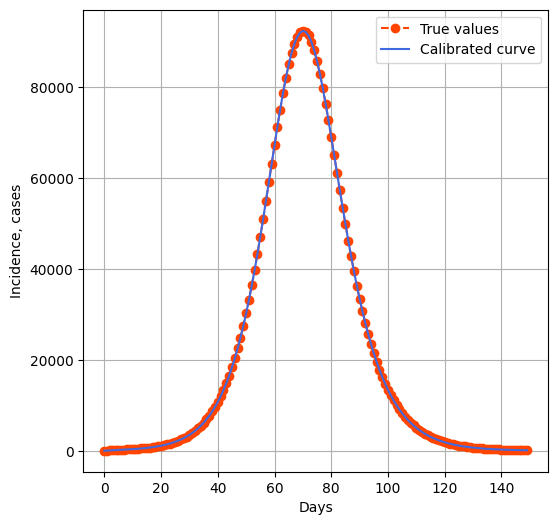

In [27]:
population = 5*1e6
mean_underreporting_arr = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
r2_arr = []
for population_scaling in tqdm.tqdm(mean_underreporting_arr):
    r2_cur_arr = []
    for mean_underreporting in mean_underreporting_arr:
        model = SEIRModel(population=population*population_scaling)
        error_model = NaiveErrorModel(data_full.daily_incidence, mean_delay=0, 
                                        mean_underreporting=mean_underreporting, error_mode='fixed')
        error_model.add_noise()
        data = error_model.incidence_arr
        estimated_params, r2_estimated = model.calibrate(data)
        r2_cur_arr.append(r2_estimated)
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlabel('Days')
        ax.set_ylabel('Incidence, cases')
        ax.plot(data, '--o', color='OrangeRed', label='True values')
        sim = model.simulate(*estimated_params.as_list(), tmax=150)
        ax.plot(sim.daily_incidence, color='RoyalBlue', label='Calibrated curve')
        ax.grid()
        ax.legend()
        fig.savefig('../figures/calibration_population_scale_{}_underreporting_{}.png'.format(population_scaling, mean_underreporting))
    r2_arr.append(r2_cur_arr)

In [21]:
r2_arr

[[0.9999950650831775,
  0.9070921187864234,
  -0.6531157013889537,
  -4.589022818660382,
  -9.699214250774167,
  -15.331245646825103,
  -22.25917092141383,
  -30.482990074540353,
  -40.002703106204685,
  -50.8183100164068,
  -62.929810805146694],
 [0.9032368955111169,
  0.9999949568866816,
  0.9070922196445209,
  0.4191028932356242,
  -0.654595212313335,
  -2.3321637647805247,
  -4.590775961554167,
  -7.369158757200369,
  -9.699214250774167,
  -12.35324321398241,
  -15.331245646825103],
 [0.3829758155746912,
  0.9032368953430855,
  0.999991587044357,
  0.9982310211858245,
  0.899096761131842,
  0.7240966942575573,
  0.3353897107120496,
  -0.04011429751903739,
  -0.6530310938677524,
  -1.4200418655513012,
  -2.332163763756805],
 [0.020305949515347588,
  0.6556532143057988,
  0.9850885302747925,
  0.9999516770947506,
  0.9999822976526831,
  0.9815751237005927,
  0.8969431680303837,
  0.7928959862251127,
  0.6395702187223598,
  0.4164658299730237,
  -0.10367176290326241],
 [-0.06231658828

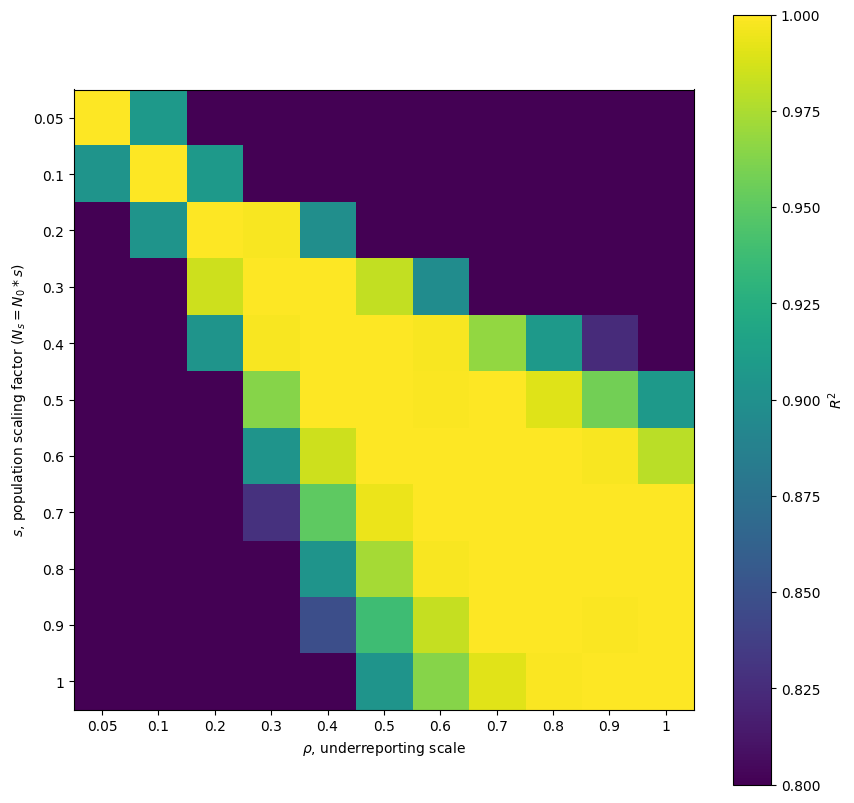

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xticks(ticks=np.arange(len(mean_underreporting_arr)), labels=[round(elem, 2) for elem in mean_underreporting_arr])
ax.set_yticks(ticks=np.arange(len(mean_underreporting_arr)), labels=[round(elem, 2) for elem in mean_underreporting_arr])

r2_numpy_arr = np.array(r2_arr)
norm = mpl.colors.Normalize(vmin=0.8, vmax=1)

im = ax.imshow(r2_numpy_arr, cmap='viridis', interpolation='nearest', norm=norm)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('$R^2$')
# ax.set_title('Colormap 2D Plot of R2 Scores')
ax.set_xlabel(r'$\rho$, underreporting scale')
ax.set_ylabel(r'$s$, population scaling factor ($N_s = N_0*s$)')
fig.savefig('../figures/colormap_r2_underreporting.pdf', bbox_inches='tight')
fig.savefig('../figures/colormap_r2_underreporting.png', bbox_inches='tight', dpi=600)